# Words With Distances — Per `count_of_chunks` Analysis

This notebook analyzes `word_jokes/words_with_distances.csv` separately for each `count_of_chunks` value (k in {2,3,4,5}).
For each k, it drops any features referencing `chunkN` where `N > k`, then runs PCA/t-SNE and clustering (KMeans).

No analysis is run on pooled rows across different `k` values.

In [2]:
# Auto-install minimal dependencies for this notebook
import importlib, sys, subprocess
pkgs = ['numpy','pandas','matplotlib','seaborn','scikit-learn']
missing = [p for p in pkgs if importlib.util.find_spec(p) is None]
if missing:
    print('Installing missing packages:', missing)
    subprocess.check_call([sys.executable, '-m', 'pip', 'install'] + missing)
else:
    print('All dependencies present.')


Installing missing packages: ['scikit-learn']


In [3]:
# Imports and setup
import os, re, warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
sns.set(context='notebook', style='whitegrid')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

data_path = 'words_with_distances.csv'
assert os.path.exists(data_path), f'File not found: {data_path}'
df = pd.read_csv(data_path)
print('Loaded shape:', df.shape)

df_frequency = pd.read_csv('hu_50k.txt', )

df.head(3)


Loaded shape: (39900, 42)


count_of_chunks  corpus chunk1 chunk2 chunk3 chunk4 chunk5  \
0                2    igen     ig     en    NaN    NaN    NaN   
1                2    kell     ke     ll    NaN    NaN    NaN   
2                2  vagyok   vagy     ok    NaN    NaN    NaN   

   cosine_distance_chunk1_and_chunk2  cosine_distance_chunk1_and_chunk3  \
0                           0.600271                                0.0   
1                           0.467889                                0.0   
2                           0.858489                                0.0   

   cosine_distance_chunk1_and_chunk4  ...  euclidean_corpus_and_chunk3  \
0                                0.0  ...                          0.0   
1                                0.0  ...                          0.0   
2                                0.0  ...                          0.0   

   euclidean_corpus_and_chunk4  euclidean_corpus_and_chunk5  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   

   cosine_corpus_and_chunk1  euclidean_corpus_and_chunk1  length_chunk1  \
0                  1.009289                     3.213454              2   
1                  0.932333                     3.443162              2   
2                  0.635981                     0.864436              4   

   length_chunk2  length_chunk3  length_chunk4  length_chunk5  
0              2              0              0              0  
1              2              0              0              0  
2              2              0              0              0  

[3 rows x 42 columns]

In [4]:
# Helpers: preprocessing, embeddings, clustering
def standardize(X: pd.DataFrame):
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X.values)
    return Xs, scaler

def embed_pca(Xs, n_components=2, random_state=RANDOM_STATE):
    pca = PCA(n_components=n_components, random_state=random_state)
    Z = pca.fit_transform(Xs)
    explained = float(np.sum(pca.explained_variance_ratio_))
    return Z, pca, explained

def embed_tsne(Xs, random_state=RANDOM_STATE, max_samples=5000):
    N = Xs.shape[0]
    if N > max_samples:
        idx = np.random.RandomState(random_state).choice(N, max_samples, replace=False)
        X_use = Xs[idx]
    else:
        X_use = Xs
    perp = max(5, min(30, (X_use.shape[0] - 1) // 3))
    tsne = TSNE(n_components=2, learning_rate=200.0, init='pca', perplexity=perp, random_state=random_state, verbose=0)
    Z = tsne.fit_transform(X_use)
    return Z

def best_kmeans(Z, k_min=2, k_max=10, random_state=RANDOM_STATE):
    best = None
    for k in range(k_min, k_max+1):
        km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels = km.fit_predict(Z)
        if len(set(labels)) == 1:
            continue
        try:
            sil = silhouette_score(Z, labels)
        except Exception:
            sil = -1.0
        ch = calinski_harabasz_score(Z, labels)
        db = davies_bouldin_score(Z, labels)
        score_tuple = (sil, ch, -db)
        if (best is None) or (score_tuple > best['score_tuple']):
            best = {'k': k, 'labels': labels, 'model': km, 'silhouette': sil, 'calinski': ch, 'davies': db, 'score_tuple': score_tuple}
    return best


def plot_embedding(Z, labels=None, title='', ax=None, palette='tab10'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))
    if labels is None:
        sns.scatterplot(x=Z[:,0], y=Z[:,1], s=12, ax=ax, color='steelblue', edgecolor=None)
    else:
        sns.scatterplot(x=Z[:,0], y=Z[:,1], hue=labels, palette=palette, s=12, ax=ax, linewidth=0)
        ax.legend(title='cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlabel('dim1')
    ax.set_ylabel('dim2')
    ax.set_title(title)
    return ax

def summarize_clusters(Z, labels, name):
    labels = np.array(labels)
    uniq, counts = np.unique(labels, return_counts=True)
    print(name, 'cluster counts:', dict(zip(uniq.tolist(), counts.tolist())))
    try:
        sil = silhouette_score(Z, labels) if len(set(labels))>1 else np.nan
    except Exception:
        sil = np.nan
    try:
        ch = calinski_harabasz_score(Z, labels) if len(set(labels))>1 else np.nan
    except Exception:
        ch = np.nan
    try:
        db = davies_bouldin_score(Z, labels) if len(set(labels))>1 else np.nan
    except Exception:
        db = np.nan
    print('metrics -> silhouette:', sil, ' calinski:', ch, ' davies:', db)

def prep_feature_matrix(df, cols):
    cols = [c for c in cols if c in df.columns]  # guard
    X = df[cols].copy()
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.dropna(axis=0)
    return X

chunk_pat = re.compile(r'chunk(\d+)')
def max_chunk_index_in_col(name: str):
    idxs = [int(m) for m in chunk_pat.findall(name)]
    return max(idxs) if idxs else None

def filter_cols_for_k(cols, k, exclude={'count_of_chunks'}):
    ok = []
    for c in cols:
        if c in exclude:
            continue
        mx = max_chunk_index_in_col(c)
        if mx is None:
            # We only keep features that explicitly reference valid chunk indices
            continue
        if mx <= k:
            ok.append(c)
    return ok


## Run Per-k Analyses (k ∈ {2,3,4,5})
For each k, filter rows and columns, then embed (PCA/t-SNE) and cluster (KMeans).

count_of_chunks = 2
Rows in group: 21809
Feature counts (after filtering by k):
  cosine_only: 3
  euclidean_only: 3
  lengths_only: 2
  cosine+lengths: 5
  euclidean+lengths: 5


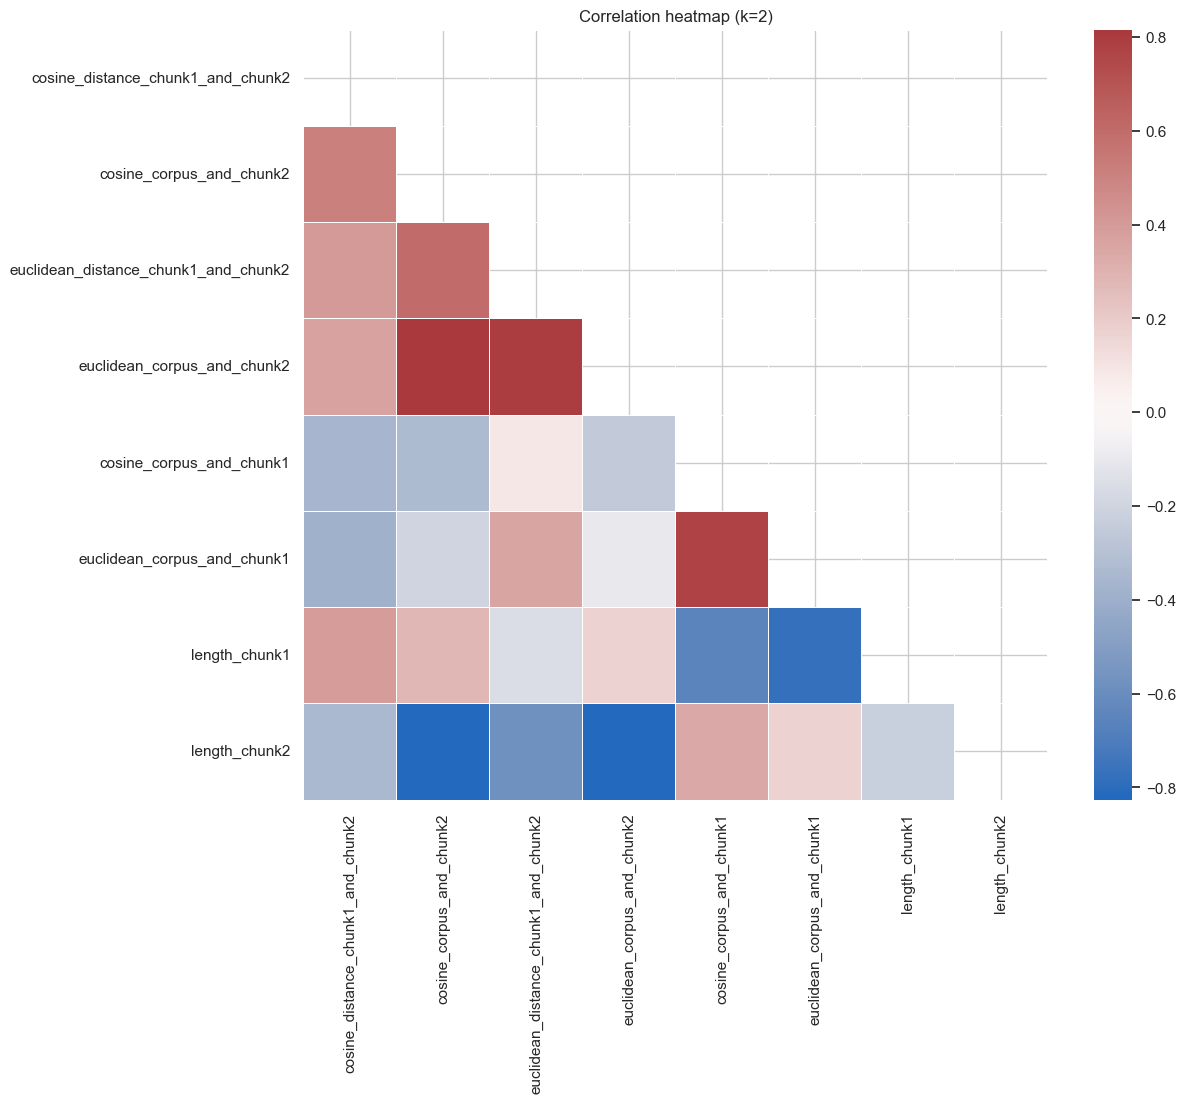

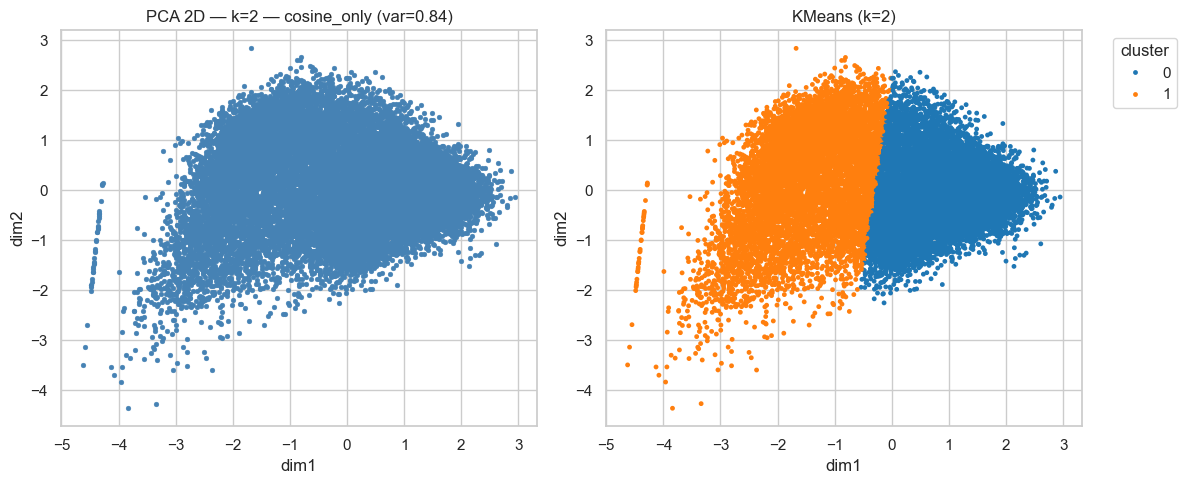

k=2 — cosine_only — KMeans on PCA:
kmeans_pca cluster counts: {0: 13598, 1: 8211}
metrics -> silhouette: 0.4872426480419545  calinski: 24526.754072187294  davies: 0.8393286772356879
Computing t-SNE 2D (may subsample for speed)...


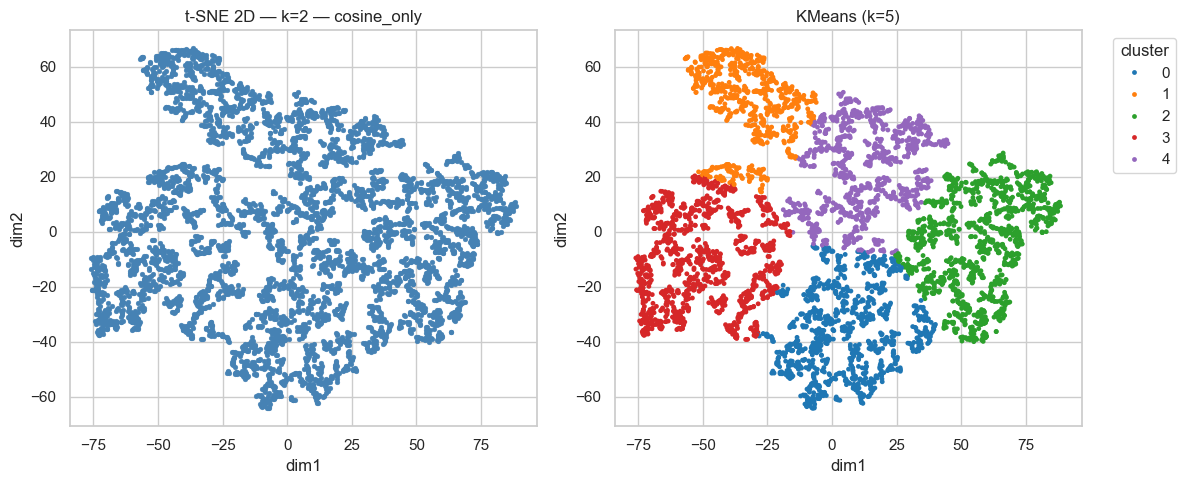

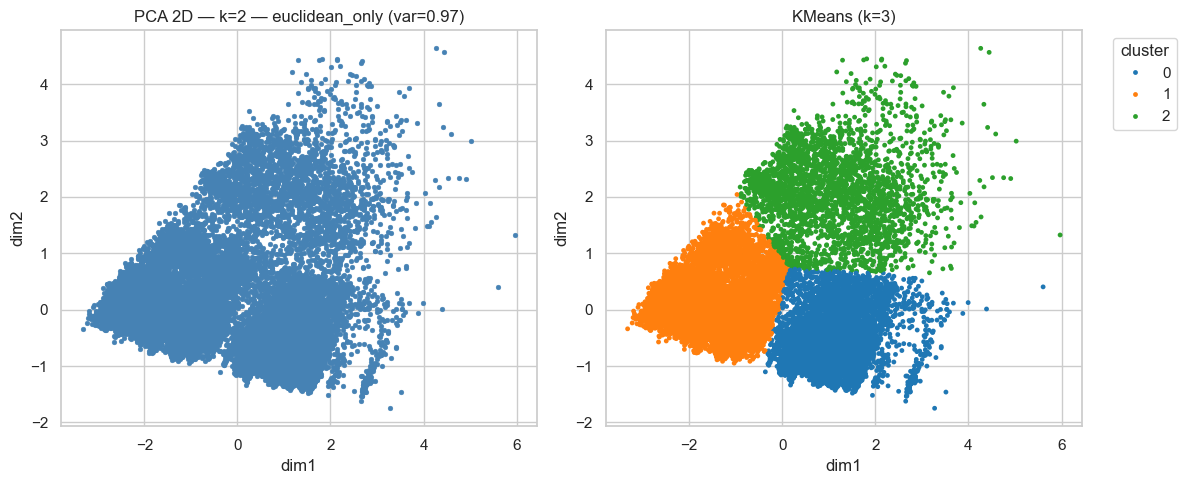

k=2 — euclidean_only — KMeans on PCA:
kmeans_pca cluster counts: {0: 9623, 1: 9289, 2: 2897}
metrics -> silhouette: 0.5455513086770427  calinski: 28133.40345417983  davies: 0.65420206808905
Computing t-SNE 2D (may subsample for speed)...


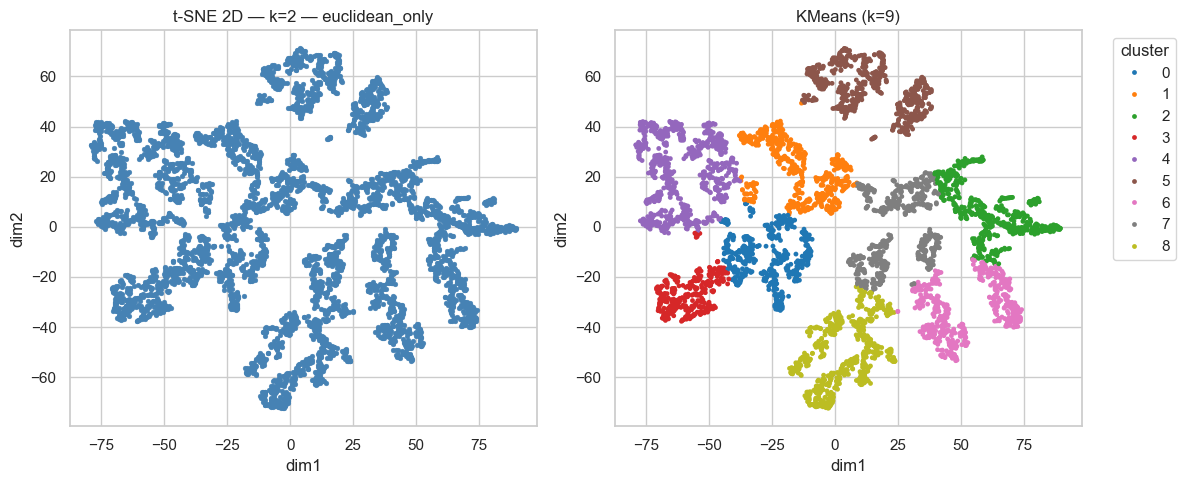

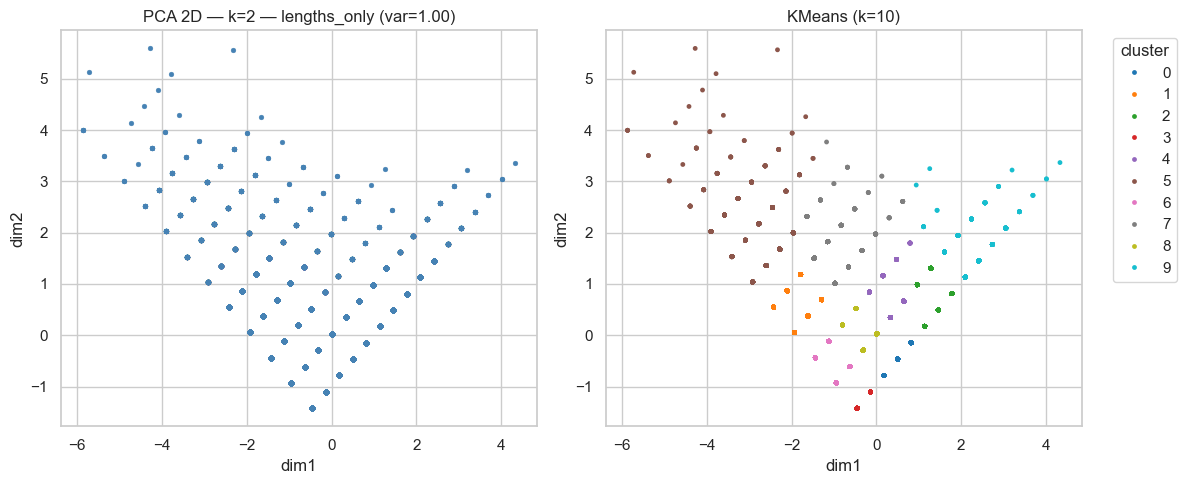

k=2 — lengths_only — KMeans on PCA:
kmeans_pca cluster counts: {0: 5089, 1: 1534, 2: 3246, 3: 2642, 4: 1693, 5: 740, 6: 2607, 7: 725, 8: 2769, 9: 764}
metrics -> silhouette: 0.5110450540042584  calinski: 23615.521133584796  davies: 0.7549815769280629
Computing t-SNE 2D (may subsample for speed)...


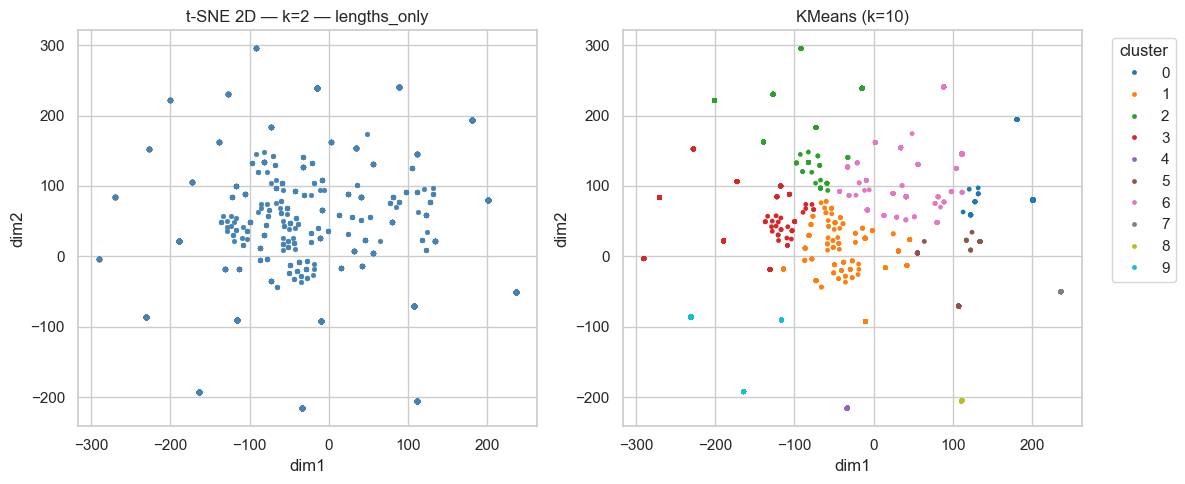

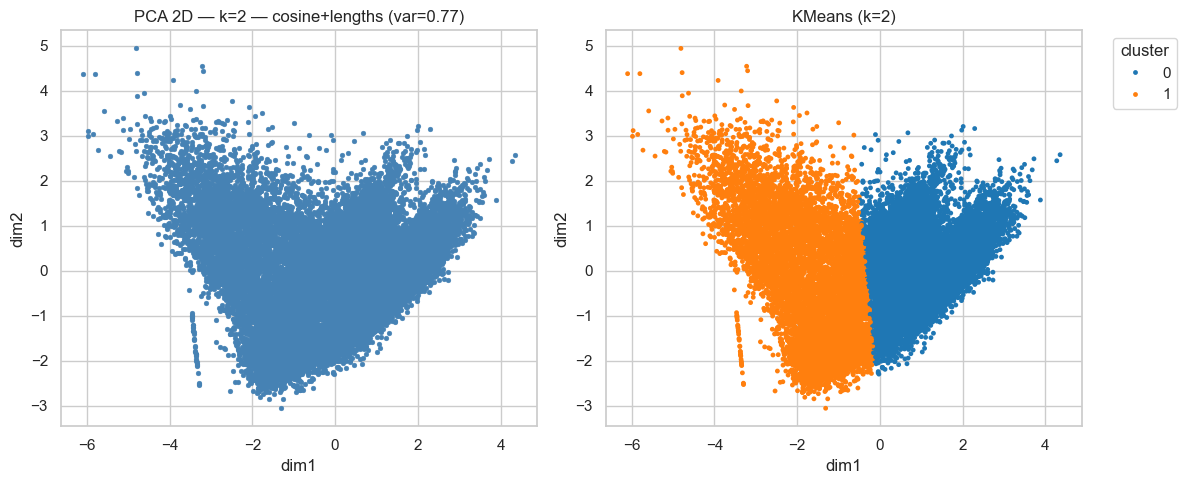

k=2 — cosine+lengths — KMeans on PCA:
kmeans_pca cluster counts: {0: 13425, 1: 8384}
metrics -> silhouette: 0.47159333296719386  calinski: 22610.094619515636  davies: 0.885560699712765
Computing t-SNE 2D (may subsample for speed)...


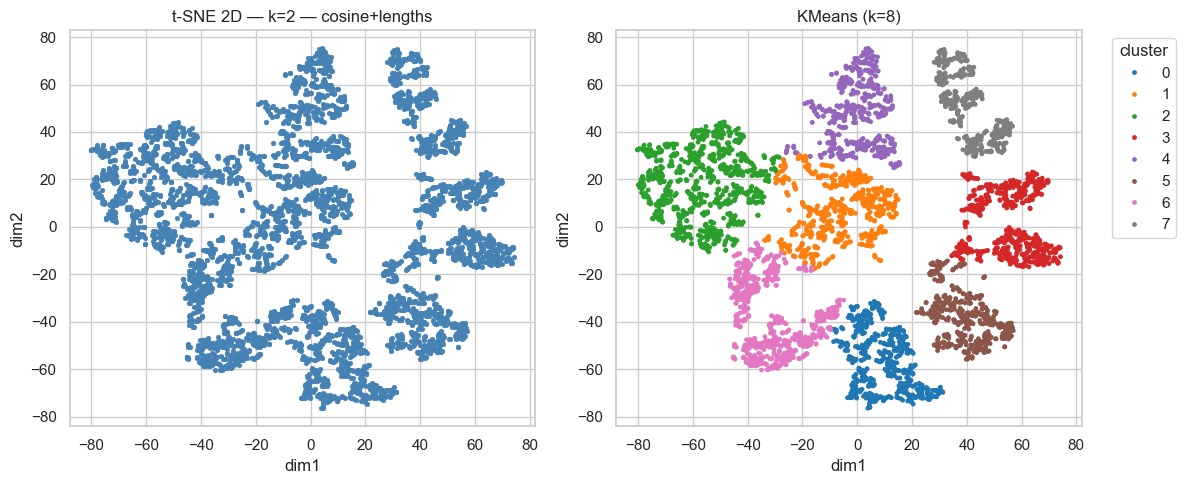

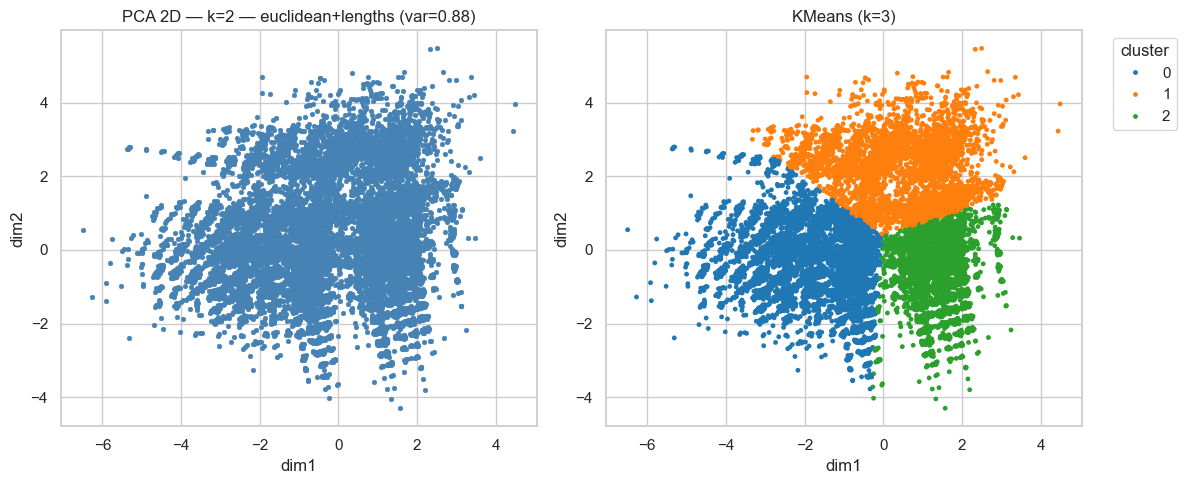

k=2 — euclidean+lengths — KMeans on PCA:
kmeans_pca cluster counts: {0: 8790, 1: 4633, 2: 8386}
metrics -> silhouette: 0.4324371950042164  calinski: 18006.776599012144  davies: 0.8252459832071036
Computing t-SNE 2D (may subsample for speed)...


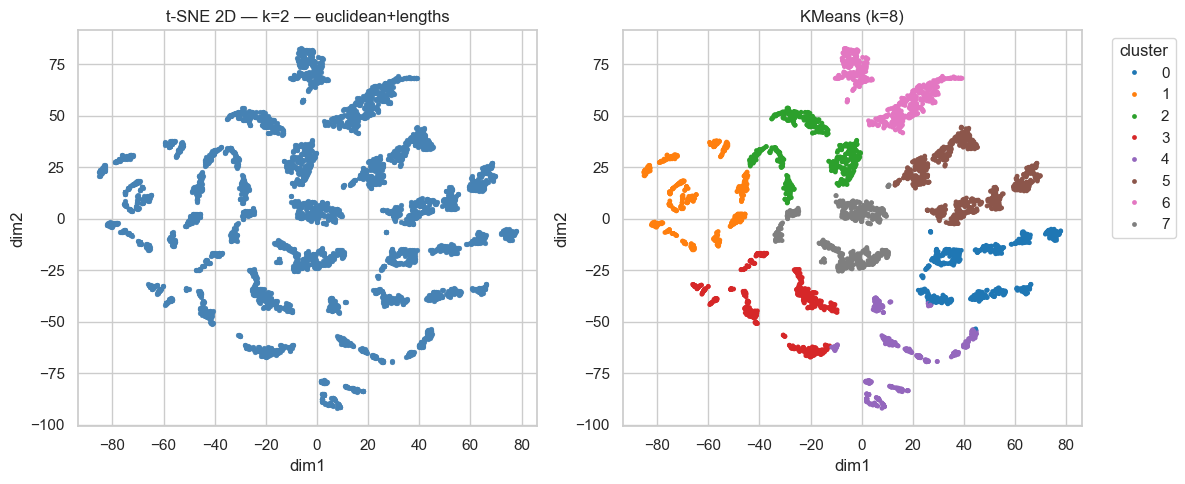

count_of_chunks = 3
Rows in group: 12178
Feature counts (after filtering by k):
  cosine_only: 6
  euclidean_only: 6
  lengths_only: 3
  cosine+lengths: 9
  euclidean+lengths: 9


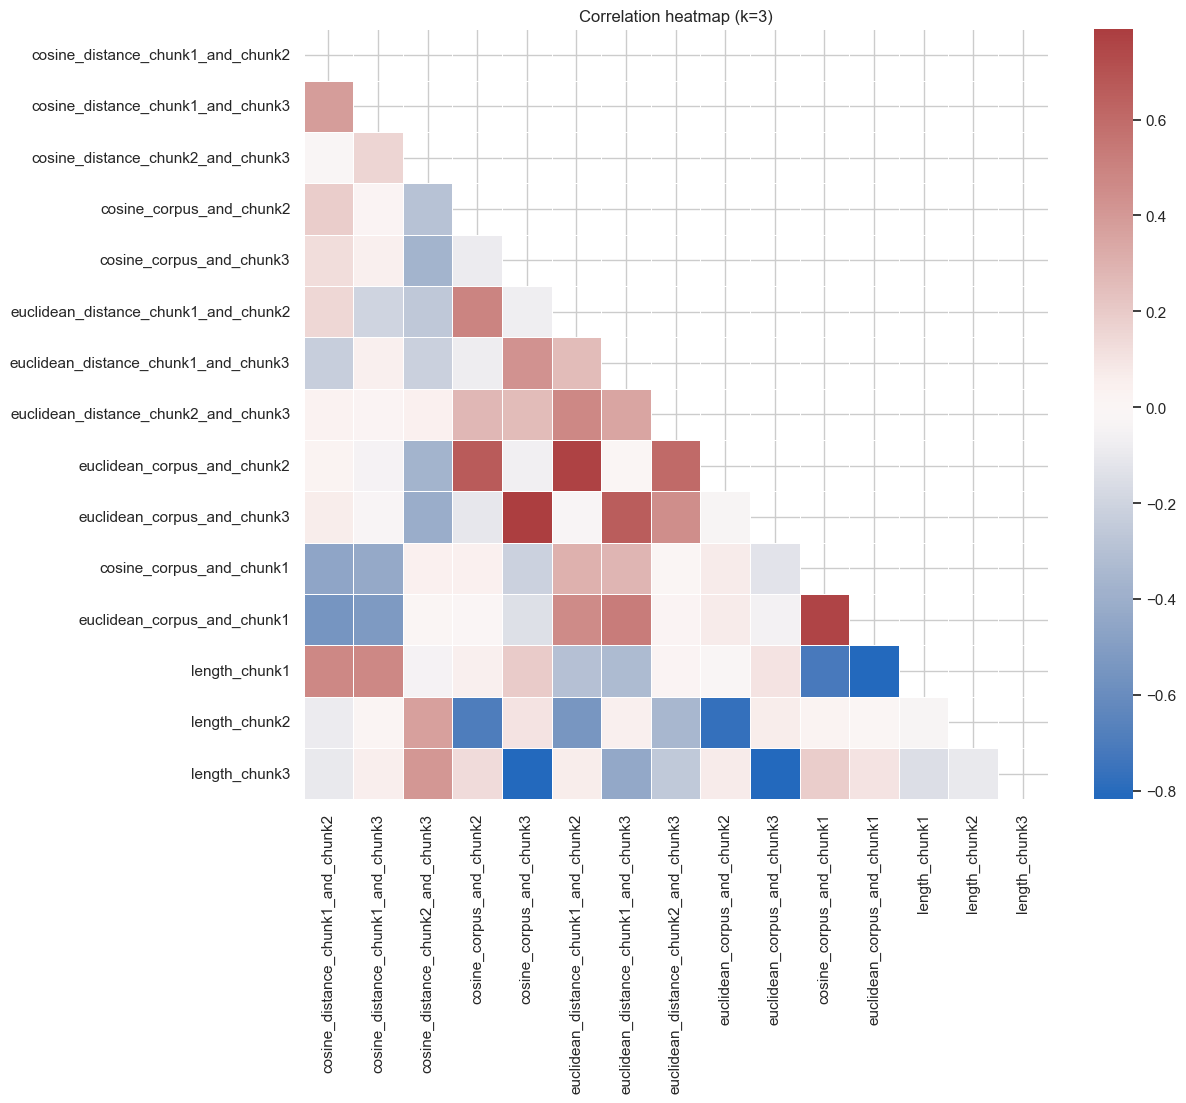

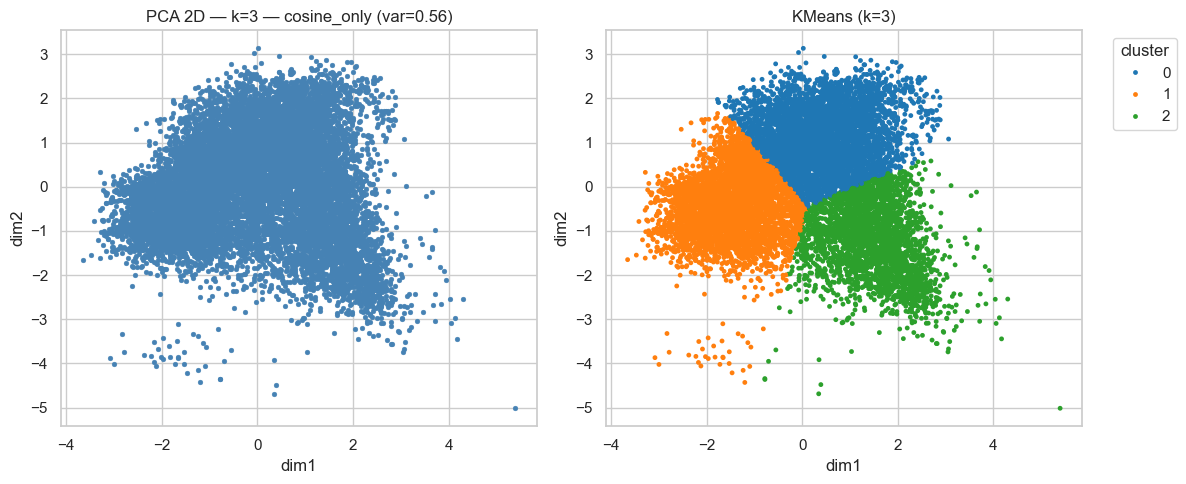

k=3 — cosine_only — KMeans on PCA:
kmeans_pca cluster counts: {0: 4938, 1: 4397, 2: 2843}
metrics -> silhouette: 0.4504185506623817  calinski: 12809.8262916746  davies: 0.75202821314278
Computing t-SNE 2D (may subsample for speed)...


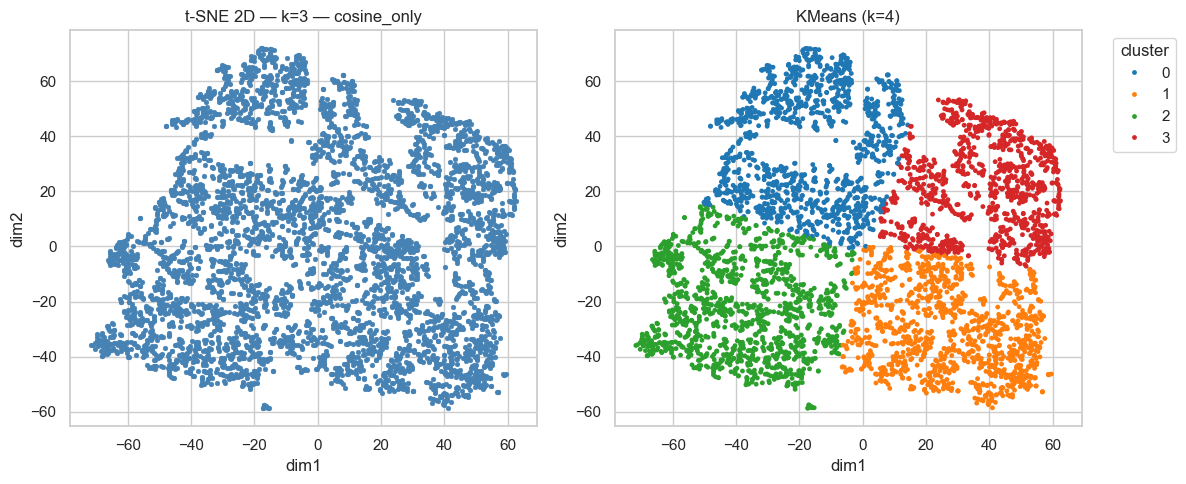

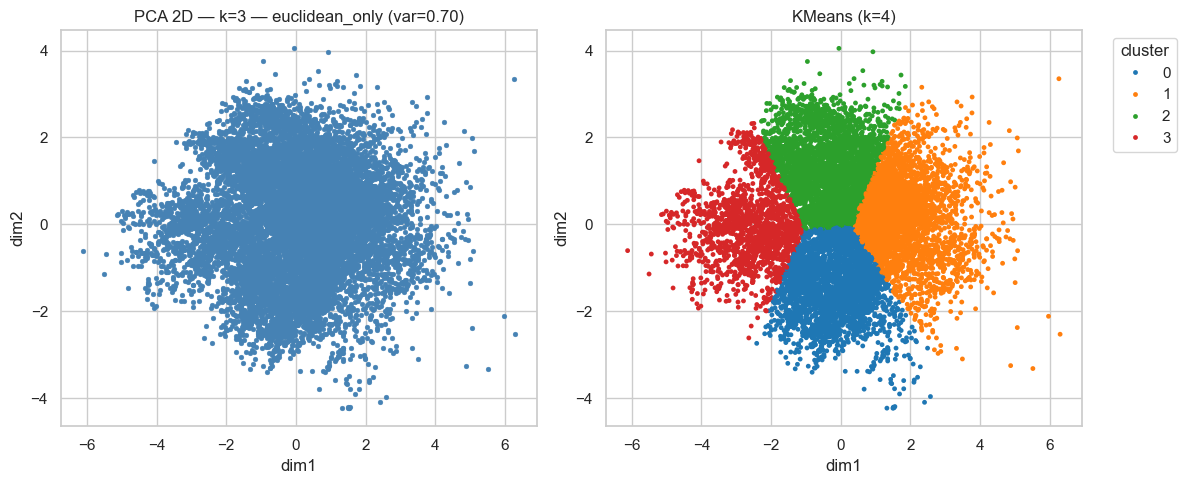

k=3 — euclidean_only — KMeans on PCA:
kmeans_pca cluster counts: {0: 3384, 1: 3609, 2: 3432, 3: 1753}
metrics -> silhouette: 0.3635779351827416  calinski: 8972.156899669297  davies: 0.8383851498922572
Computing t-SNE 2D (may subsample for speed)...


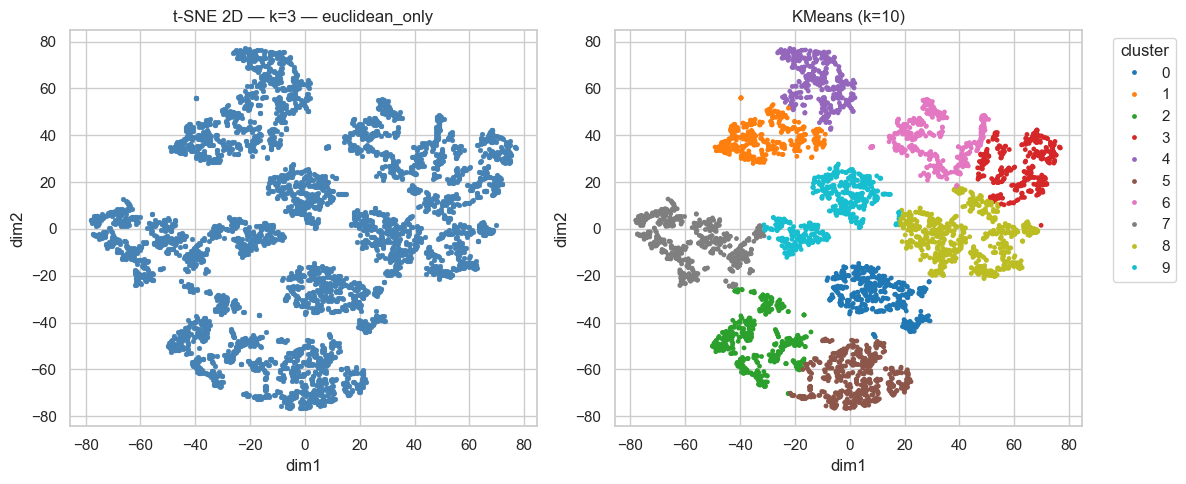

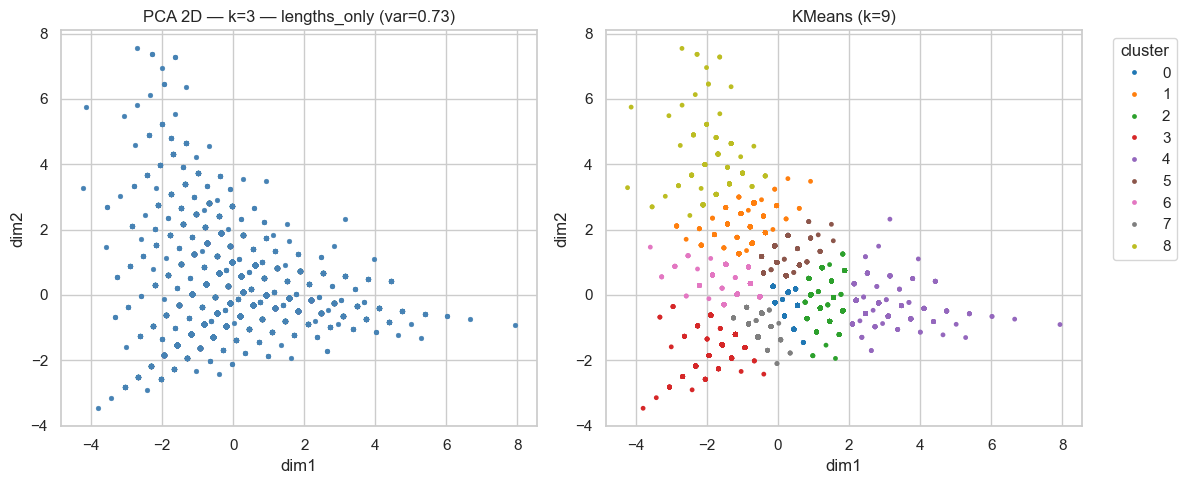

k=3 — lengths_only — KMeans on PCA:
kmeans_pca cluster counts: {0: 3629, 1: 762, 2: 1613, 3: 1034, 4: 578, 5: 1791, 6: 755, 7: 1842, 8: 174}
metrics -> silhouette: 0.4624457411868627  calinski: 10341.66723204167  davies: 0.7528496976176622
Computing t-SNE 2D (may subsample for speed)...


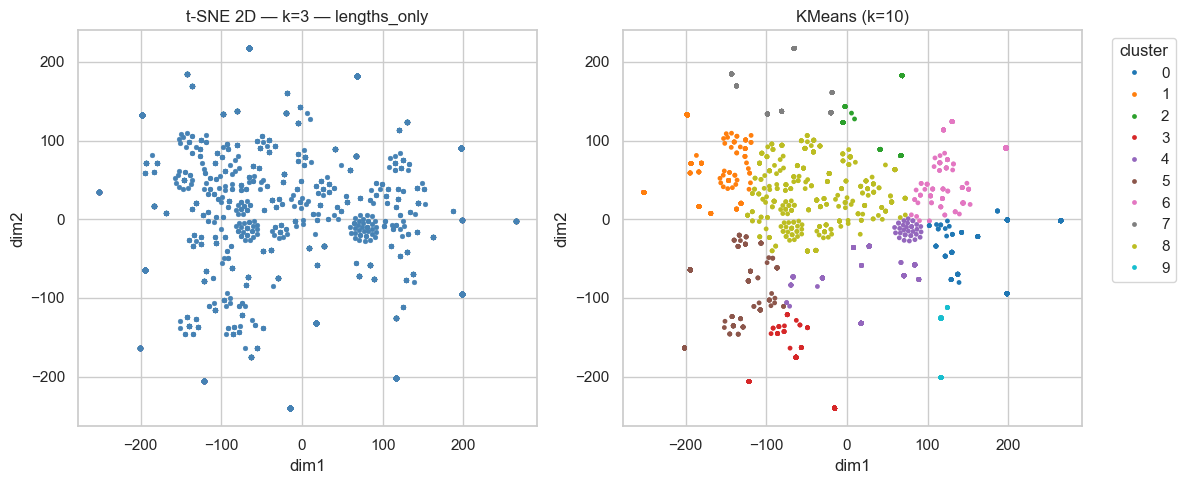

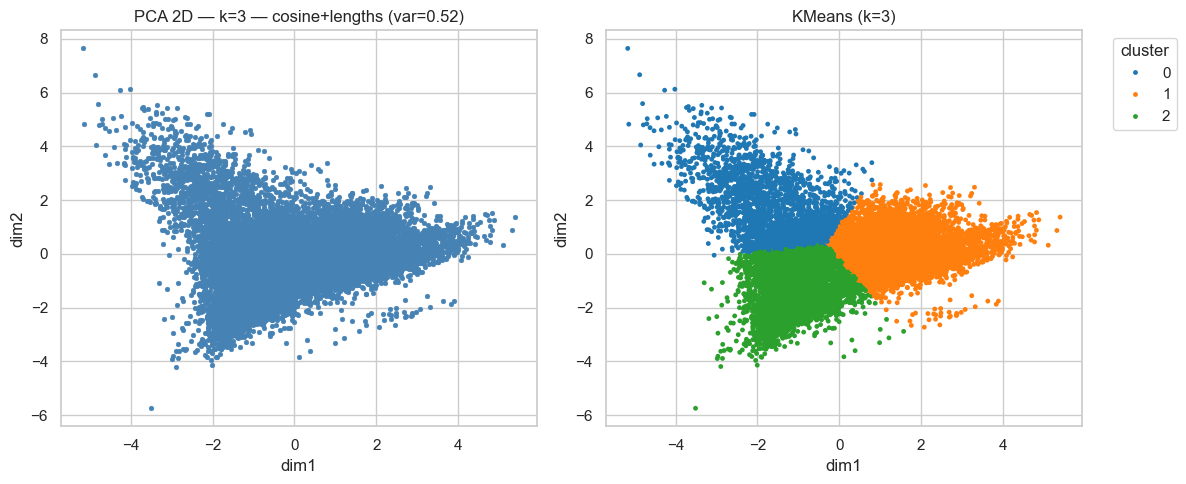

k=3 — cosine+lengths — KMeans on PCA:
kmeans_pca cluster counts: {0: 2469, 1: 5616, 2: 4093}
metrics -> silhouette: 0.4505769057756807  calinski: 11593.76204509295  davies: 0.7790237561480343
Computing t-SNE 2D (may subsample for speed)...


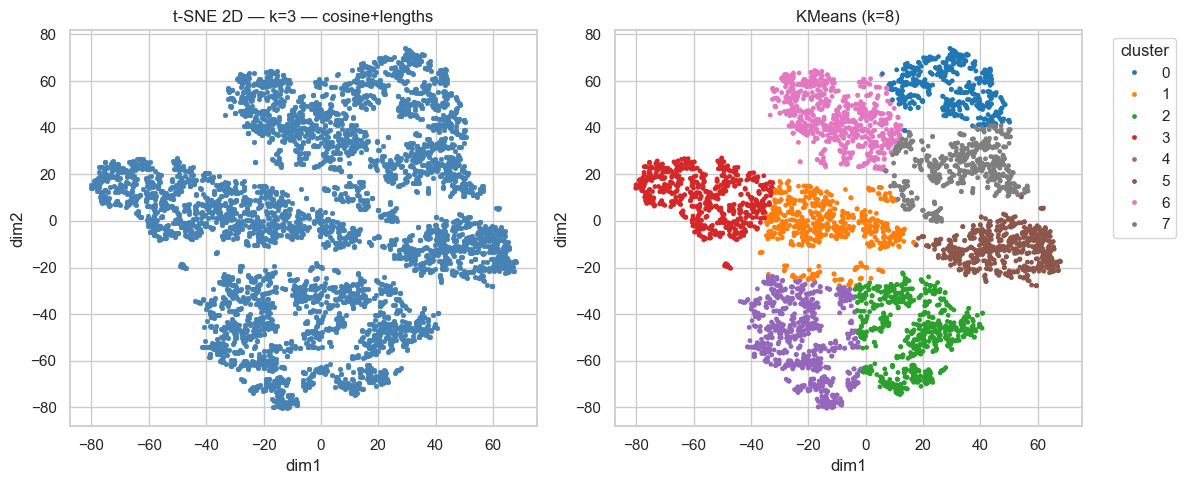

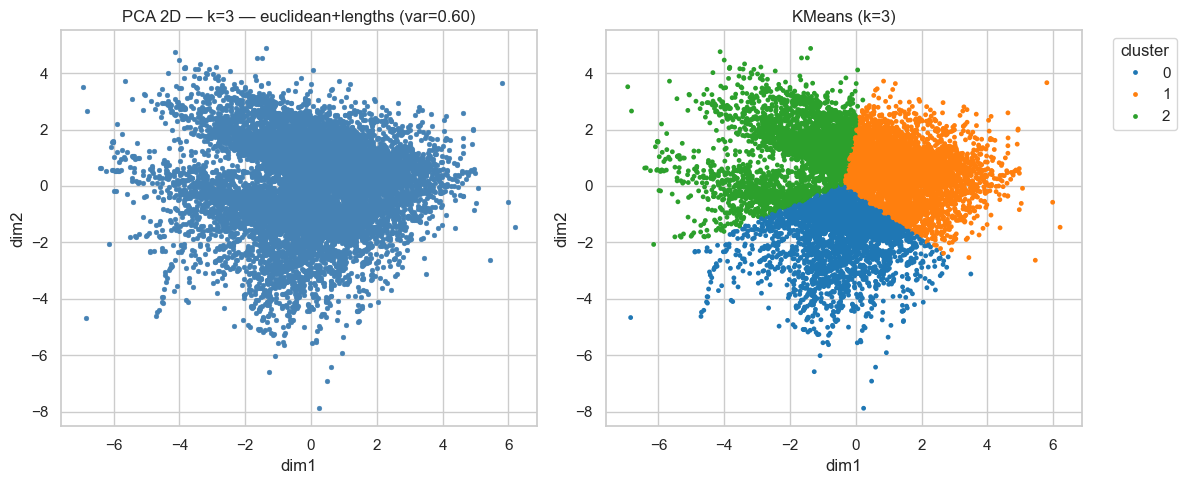

k=3 — euclidean+lengths — KMeans on PCA:
kmeans_pca cluster counts: {0: 3555, 1: 5409, 2: 3214}
metrics -> silhouette: 0.3903645928326113  calinski: 8831.590103510134  davies: 0.8636206728864012
Computing t-SNE 2D (may subsample for speed)...


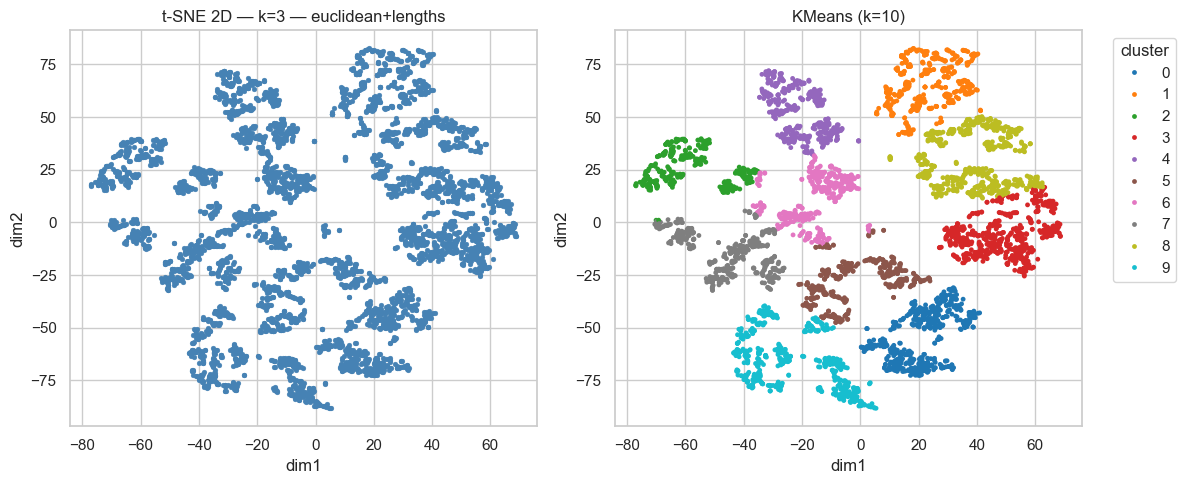

count_of_chunks = 4
Rows in group: 4731
Feature counts (after filtering by k):
  cosine_only: 10
  euclidean_only: 10
  lengths_only: 4
  cosine+lengths: 14
  euclidean+lengths: 14


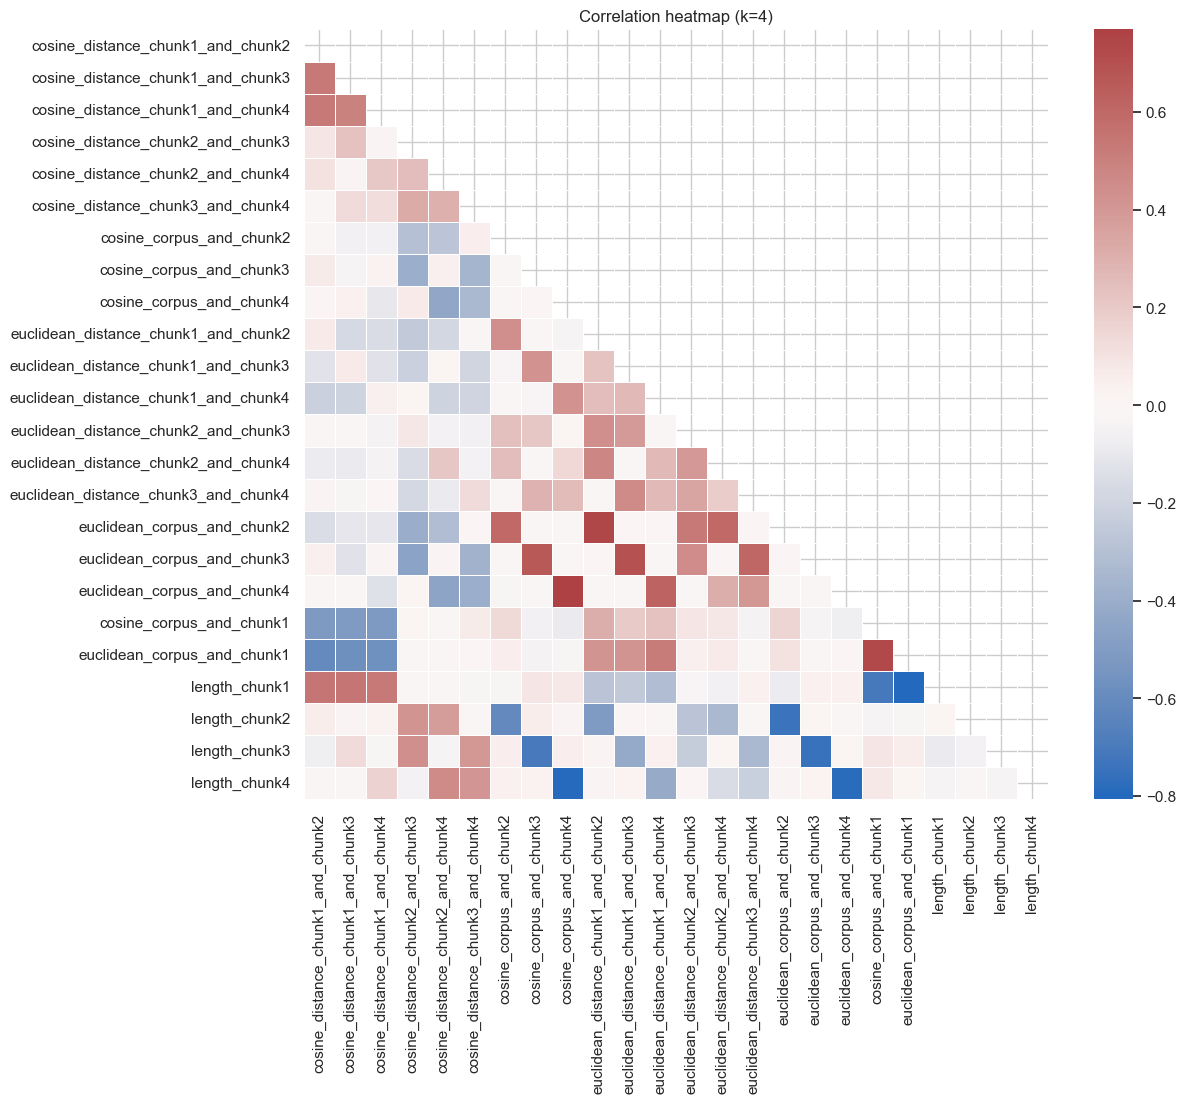

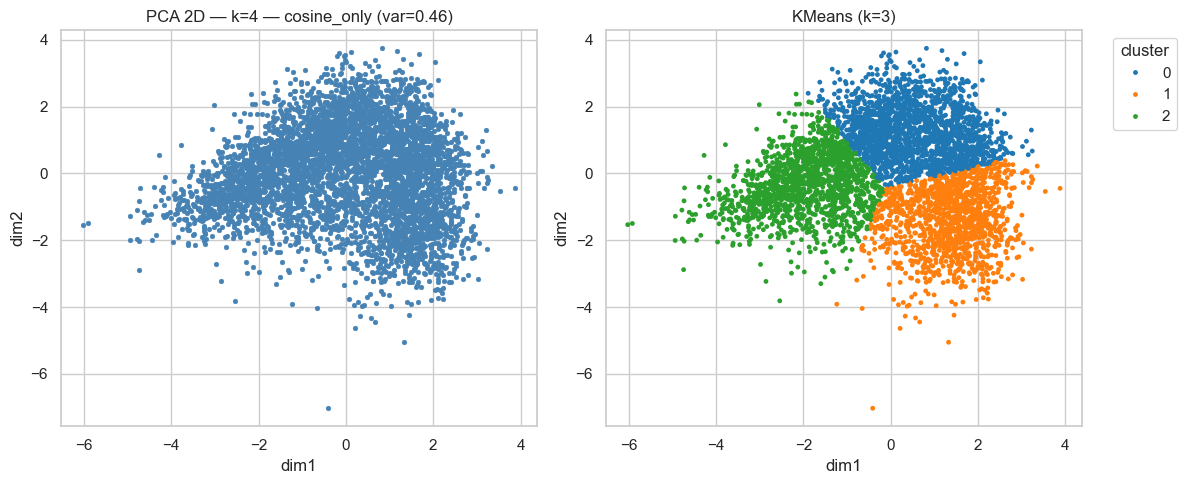

k=4 — cosine_only — KMeans on PCA:
kmeans_pca cluster counts: {0: 1915, 1: 1315, 2: 1501}
metrics -> silhouette: 0.42752609575794115  calinski: 4650.48083362926  davies: 0.7913406168309779
Computing t-SNE 2D (may subsample for speed)...


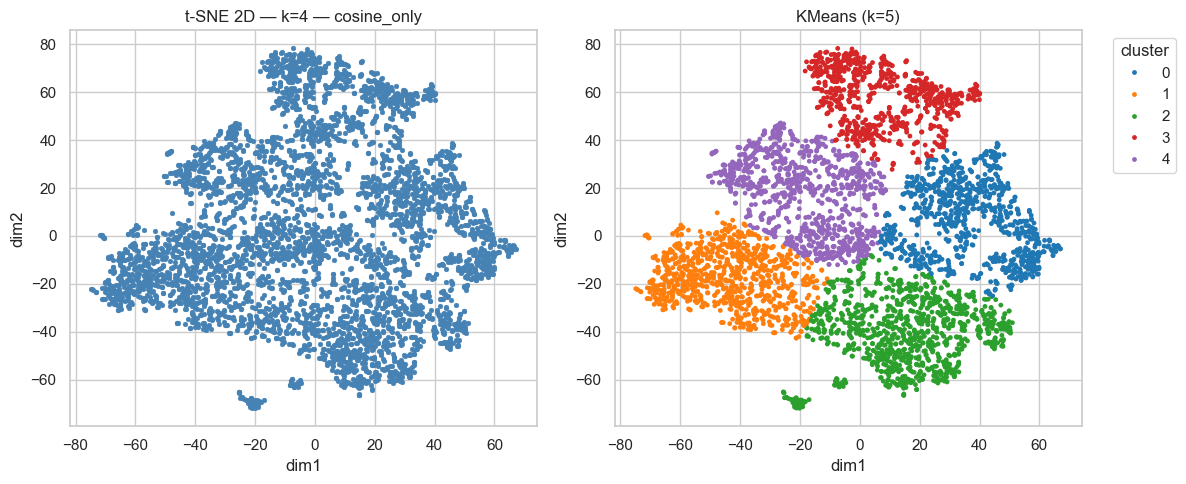

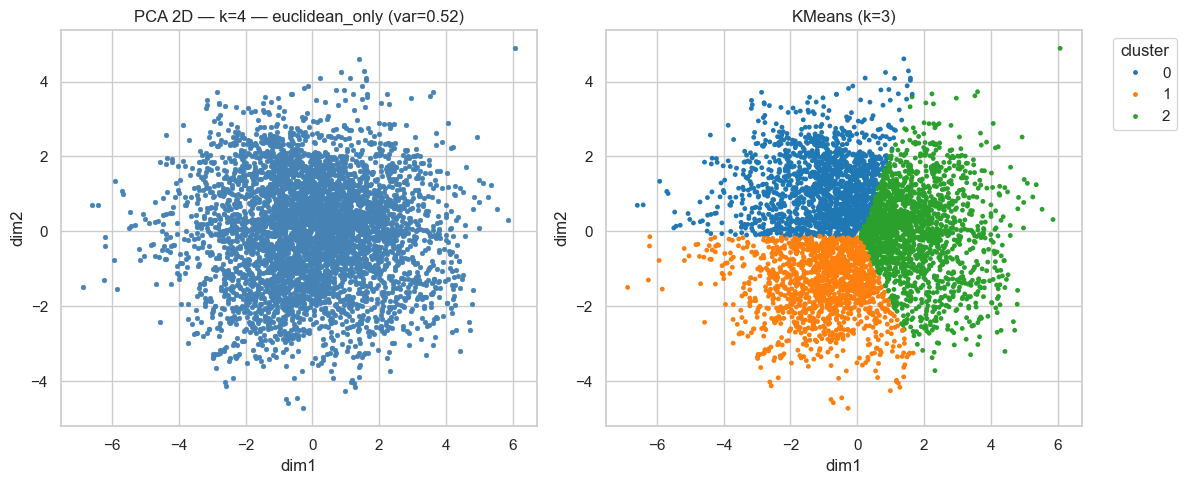

k=4 — euclidean_only — KMeans on PCA:
kmeans_pca cluster counts: {0: 1623, 1: 1379, 2: 1729}
metrics -> silhouette: 0.35001086878831955  calinski: 2998.2431665703534  davies: 0.949512598455707
Computing t-SNE 2D (may subsample for speed)...


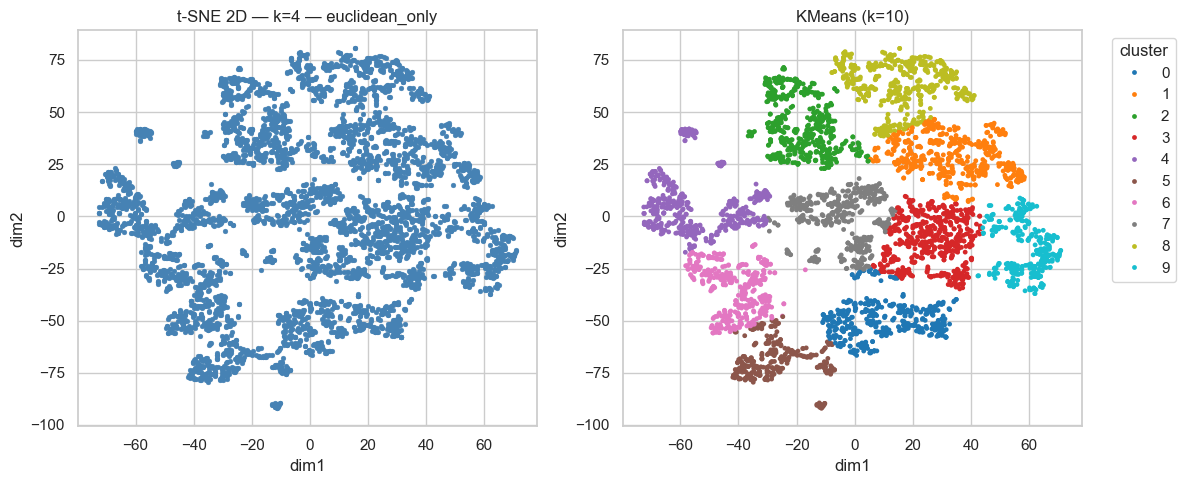

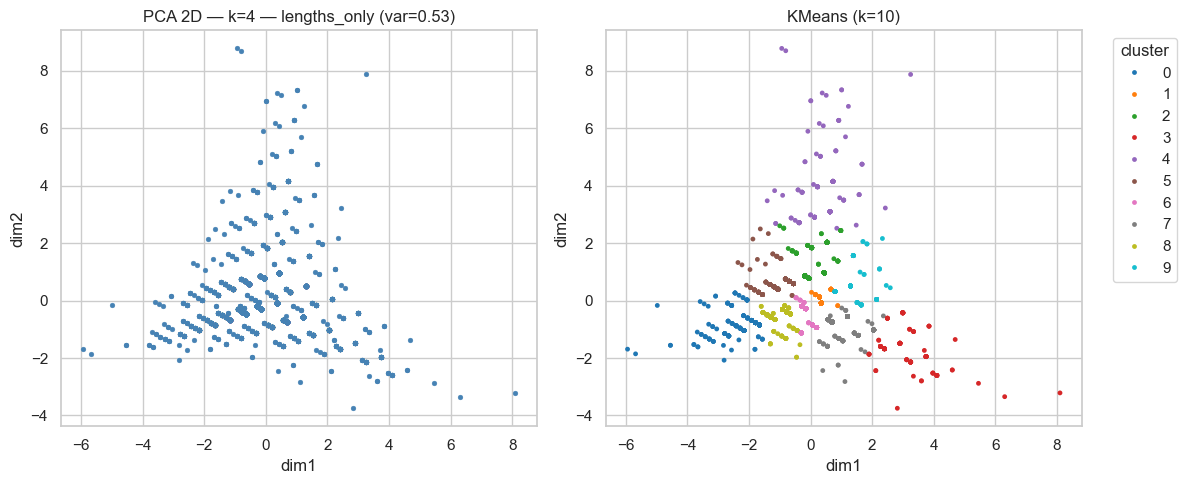

k=4 — lengths_only — KMeans on PCA:
kmeans_pca cluster counts: {0: 275, 1: 761, 2: 716, 3: 124, 4: 127, 5: 409, 6: 812, 7: 562, 8: 706, 9: 239}
metrics -> silhouette: 0.5694884695280277  calinski: 3613.8001911917945  davies: 0.64340120876852
Computing t-SNE 2D (may subsample for speed)...


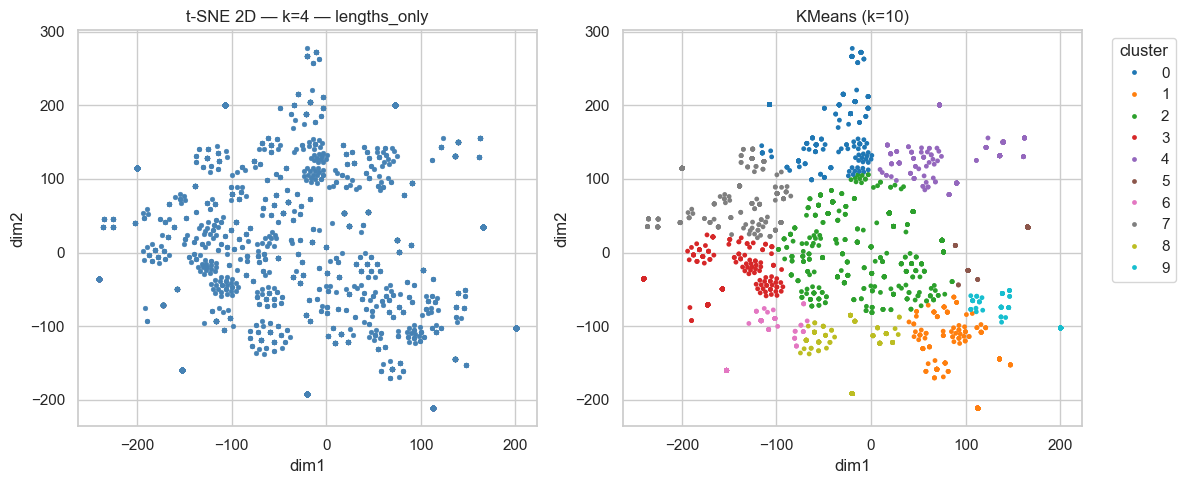

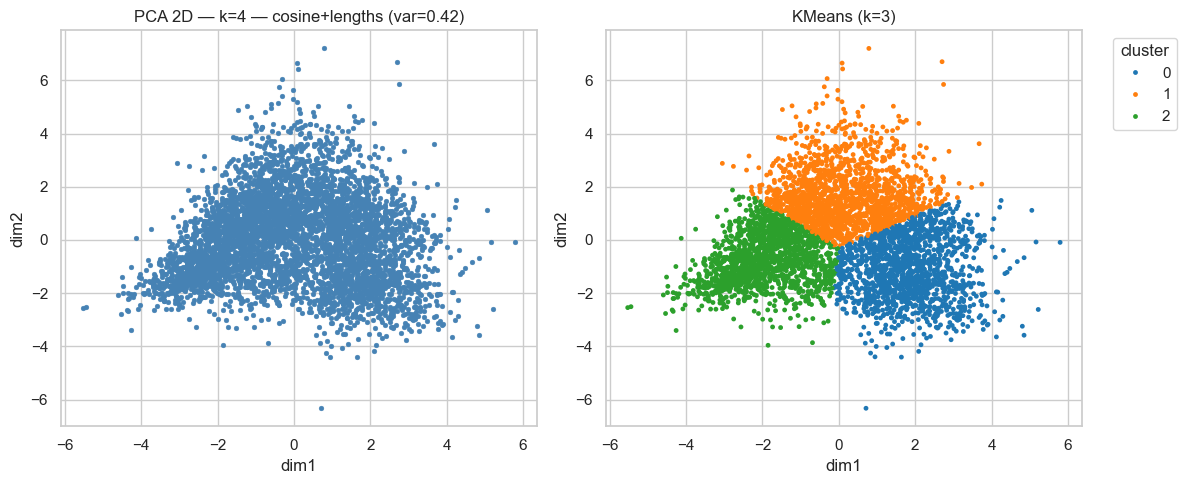

k=4 — cosine+lengths — KMeans on PCA:
kmeans_pca cluster counts: {0: 1496, 1: 1692, 2: 1543}
metrics -> silhouette: 0.4207915299958094  calinski: 4463.592392623705  davies: 0.8089400145509544
Computing t-SNE 2D (may subsample for speed)...


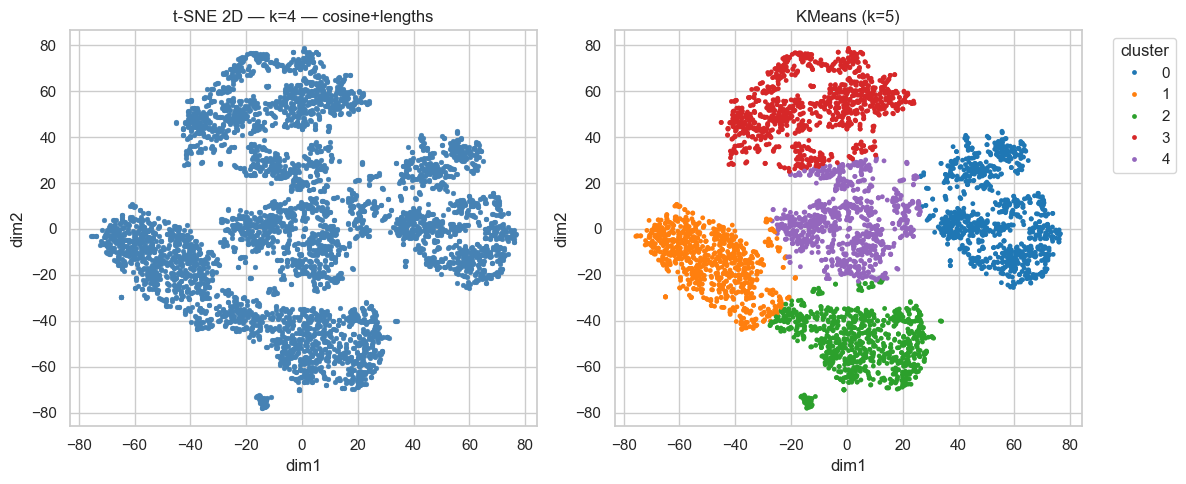

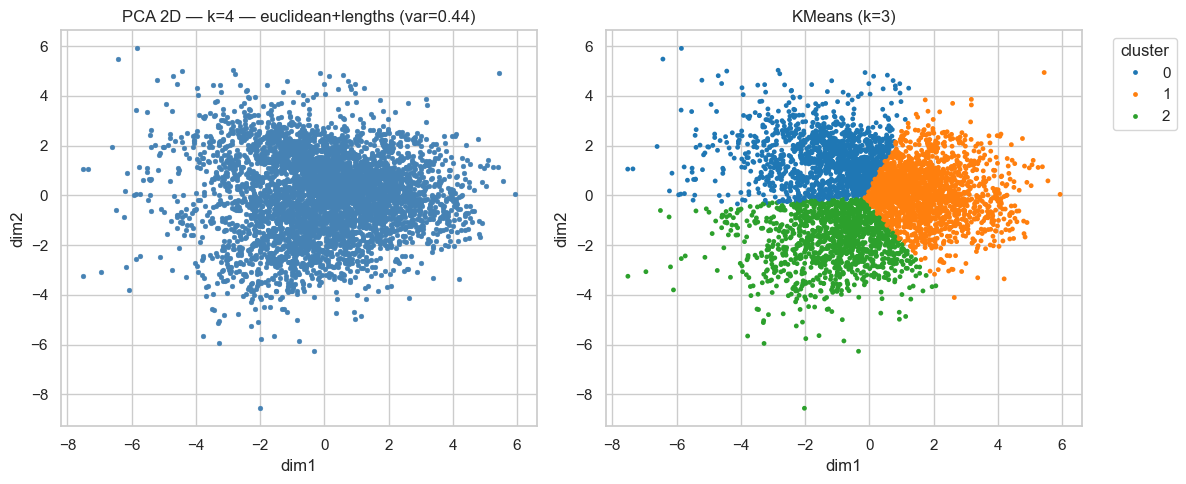

k=4 — euclidean+lengths — KMeans on PCA:
kmeans_pca cluster counts: {0: 1453, 1: 1975, 2: 1303}
metrics -> silhouette: 0.37720963737470853  calinski: 3274.539915482087  davies: 0.8778565437200495
Computing t-SNE 2D (may subsample for speed)...


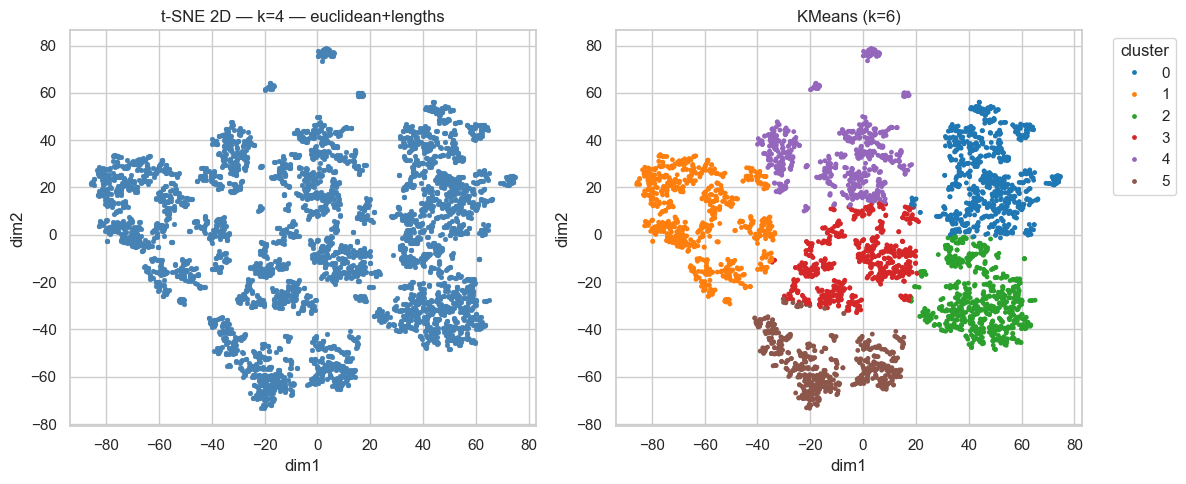

count_of_chunks = 5
Rows in group: 1182
Feature counts (after filtering by k):
  cosine_only: 15
  euclidean_only: 15
  lengths_only: 5
  cosine+lengths: 20
  euclidean+lengths: 20


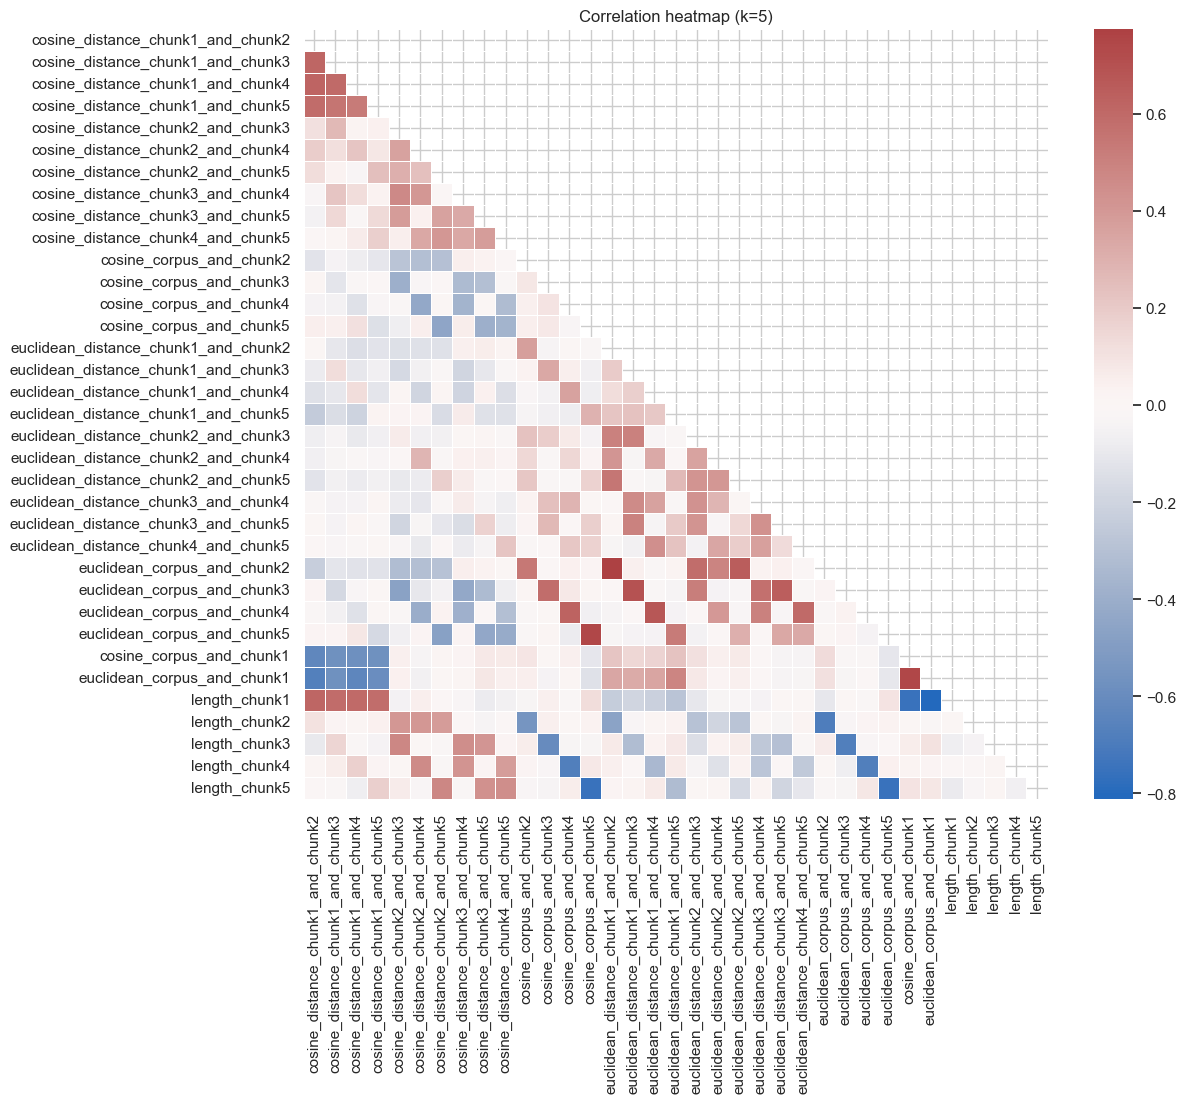

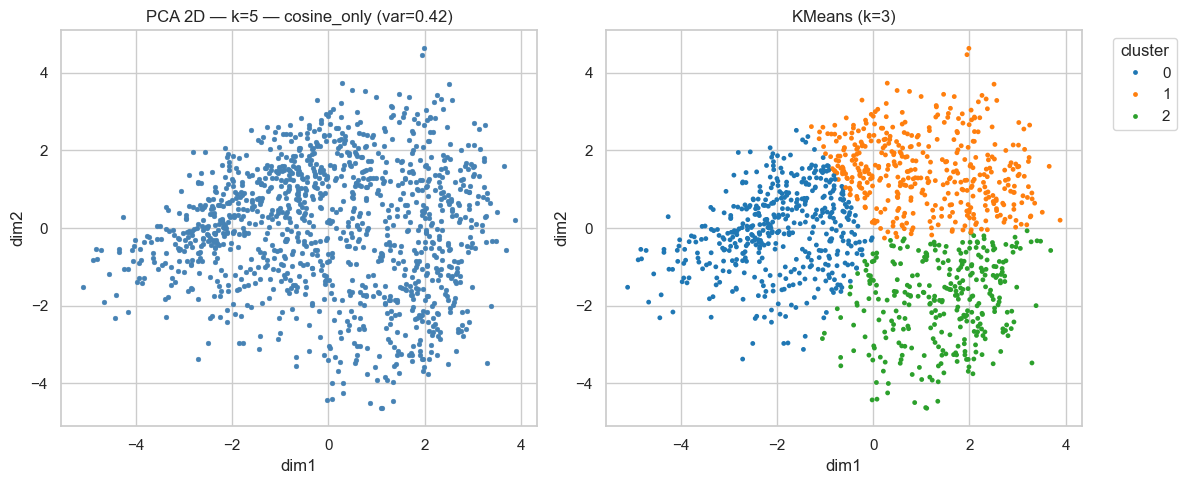

k=5 — cosine_only — KMeans on PCA:
kmeans_pca cluster counts: {0: 457, 1: 418, 2: 307}
metrics -> silhouette: 0.4161263751749334  calinski: 1108.0519886458562  davies: 0.805509064984617
Computing t-SNE 2D (may subsample for speed)...


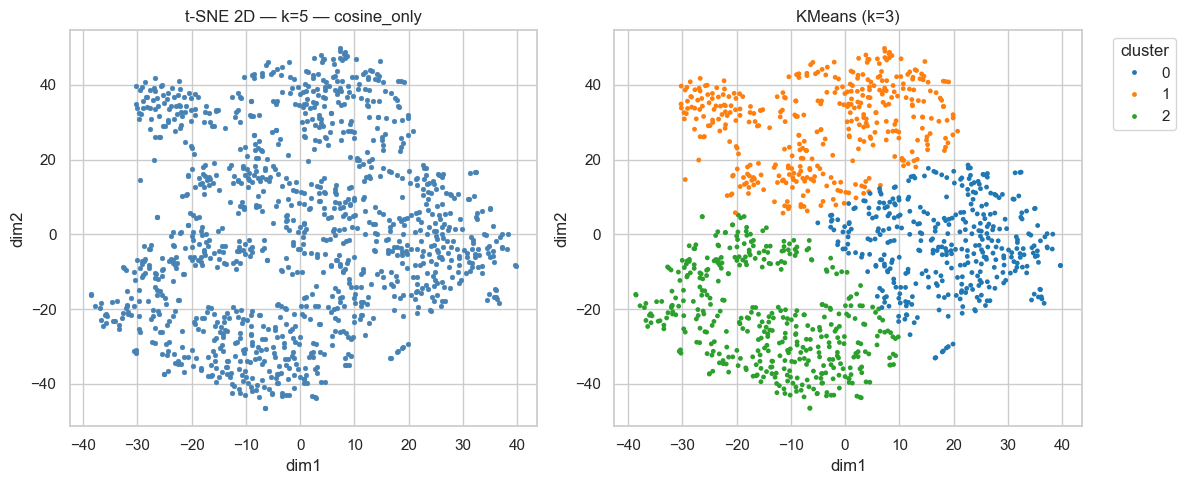

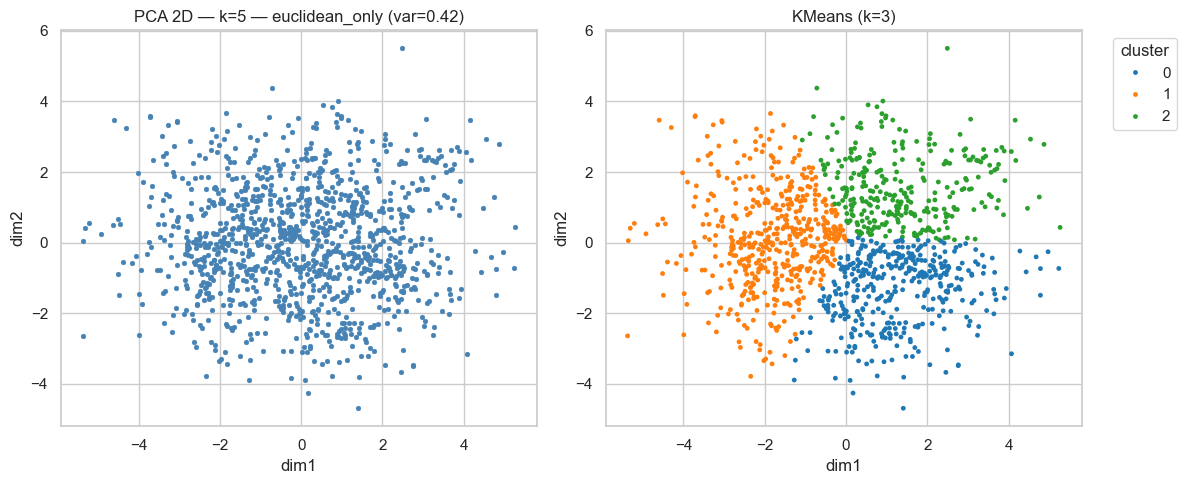

k=5 — euclidean_only — KMeans on PCA:
kmeans_pca cluster counts: {0: 386, 1: 498, 2: 298}
metrics -> silhouette: 0.36345513424240805  calinski: 818.0218022938141  davies: 0.9210738331030642
Computing t-SNE 2D (may subsample for speed)...


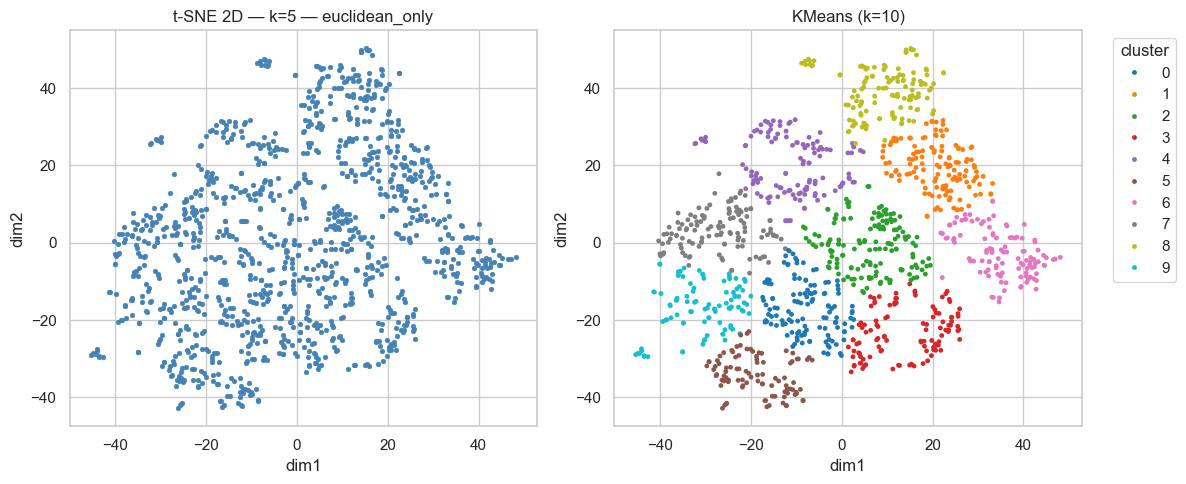

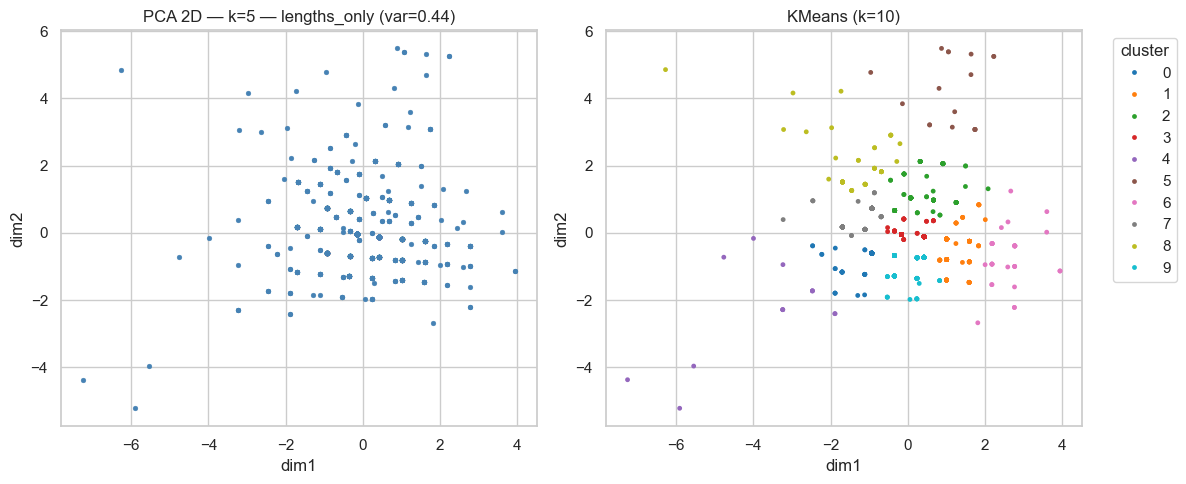

k=5 — lengths_only — KMeans on PCA:
kmeans_pca cluster counts: {0: 116, 1: 178, 2: 123, 3: 391, 4: 14, 5: 18, 6: 34, 7: 114, 8: 51, 9: 143}
metrics -> silhouette: 0.49377071859569005  calinski: 607.2199944098375  davies: 0.8330583161852194
Computing t-SNE 2D (may subsample for speed)...


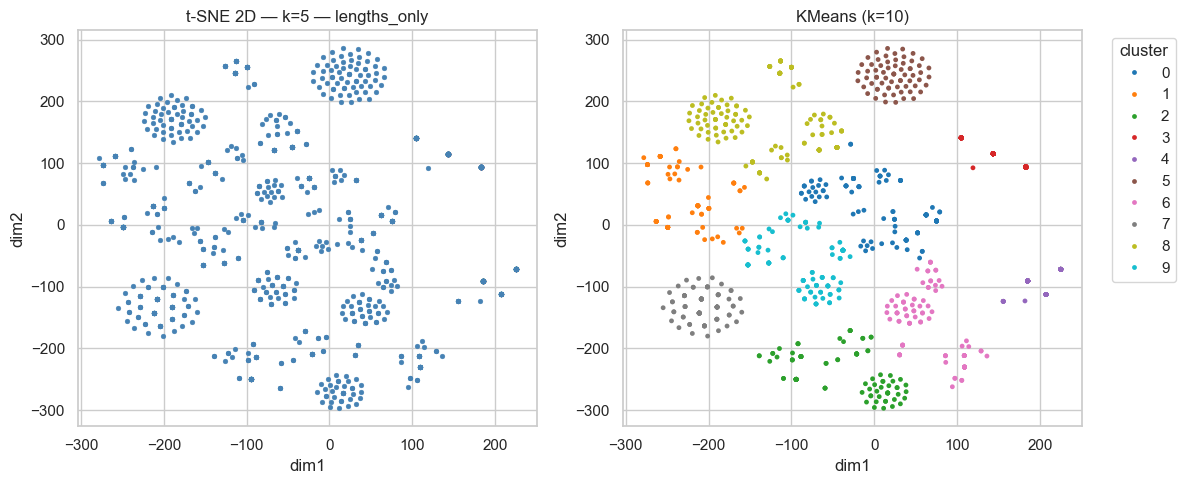

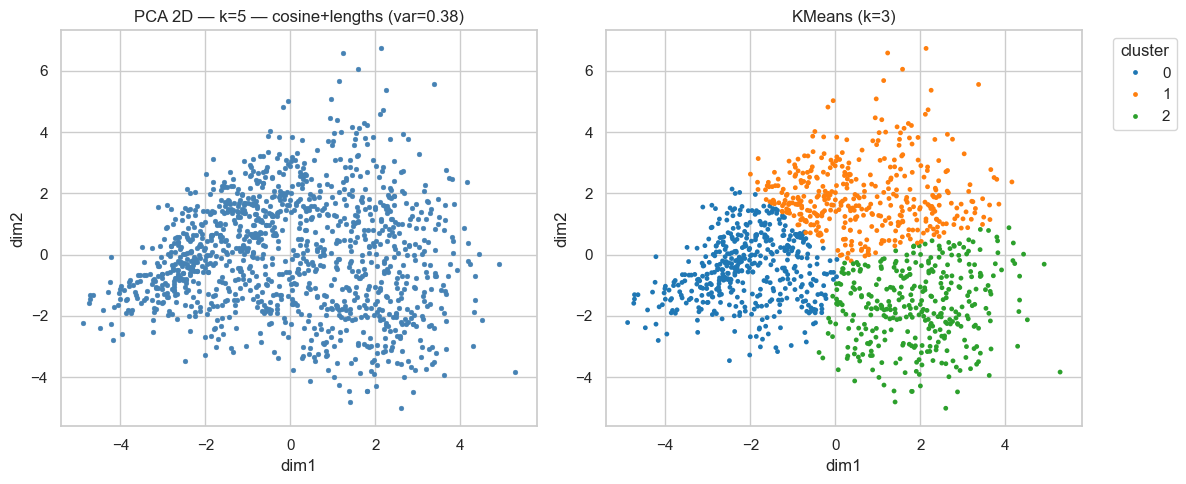

k=5 — cosine+lengths — KMeans on PCA:
kmeans_pca cluster counts: {0: 444, 1: 404, 2: 334}
metrics -> silhouette: 0.41304540535415724  calinski: 1084.214770785546  davies: 0.8166061422815227
Computing t-SNE 2D (may subsample for speed)...


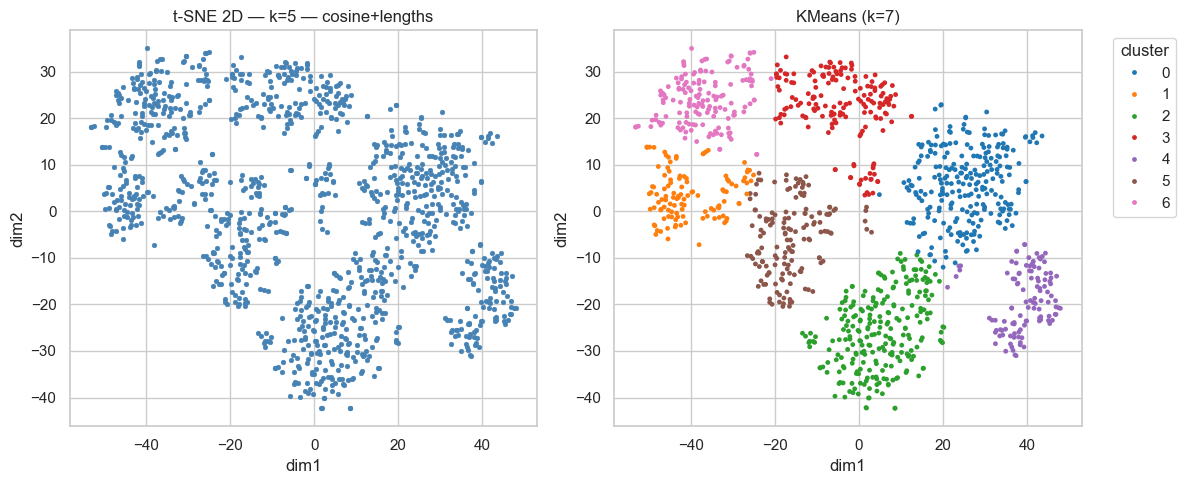

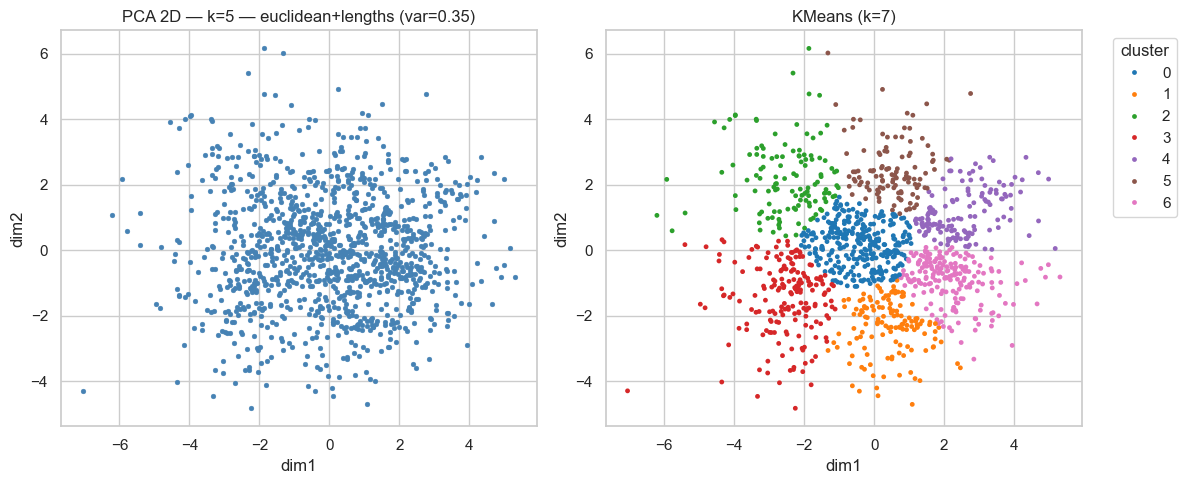

k=5 — euclidean+lengths — KMeans on PCA:
kmeans_pca cluster counts: {0: 298, 1: 135, 2: 121, 3: 183, 4: 142, 5: 112, 6: 191}
metrics -> silhouette: 0.3562774404325413  calinski: 791.5296267901226  davies: 0.8465678467180593
Computing t-SNE 2D (may subsample for speed)...


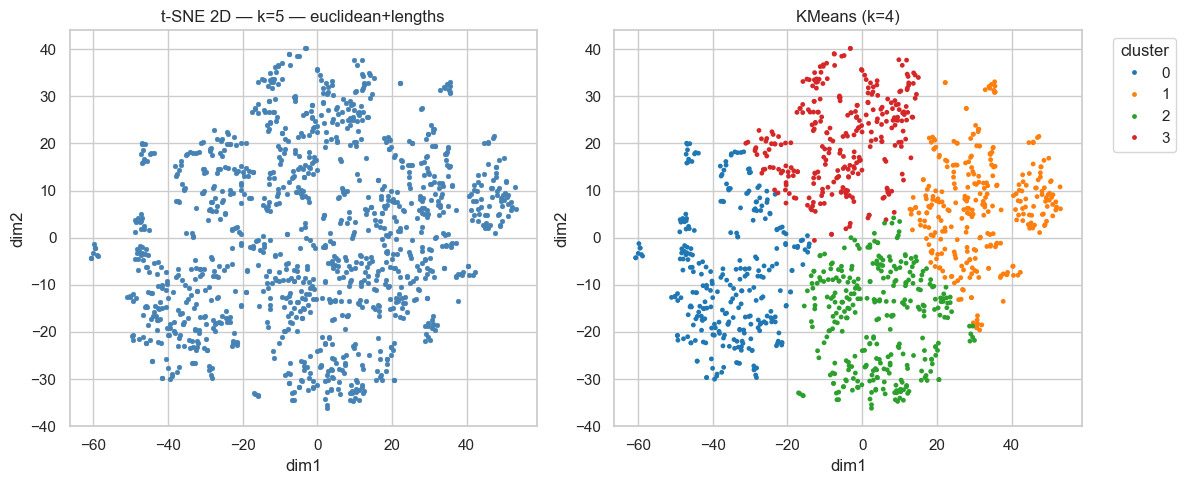

In [5]:
cosine_cols_all = [c for c in df.columns if c.startswith('cosine_')]
euclid_cols_all = [c for c in df.columns if c.startswith('euclidean_')]
length_cols_all = [c for c in df.columns if c.startswith('length_')]
base_numeric = df.select_dtypes(include=[np.number]).columns.tolist()

for k in [2,3,4,5]:
    print('' + '='*100)
    print(f'count_of_chunks = {k}')
    dfk = df[df['count_of_chunks'] == k].copy()
    print('Rows in group:', len(dfk))
    if len(dfk) < 10:
        print('Not enough rows; skipping heavy analysis for this k.')
        continue

    # Filter columns valid for this k
    all_numeric_k = filter_cols_for_k(base_numeric, k)
    cos_k = filter_cols_for_k(cosine_cols_all, k)
    euc_k = filter_cols_for_k(euclid_cols_all, k)
    len_k = filter_cols_for_k(length_cols_all, k)
    features_k = {
        'cosine_only': cos_k,
        'euclidean_only': euc_k,
        'lengths_only': len_k,
        'cosine+lengths': list(dict.fromkeys(cos_k + len_k)),
        'euclidean+lengths': list(dict.fromkeys(euc_k + len_k)),
        # Optionally: 'all_numeric': all_numeric_k,  # excluded to avoid mixing any non-chunk-indexed cols
    }
    print('Feature counts (after filtering by k):')
    for key, cols in features_k.items():
        print(f'  {key}: {len(cols)}')

    # Correlation heatmap per k (numeric-only, filtered)
    if all_numeric_k:
        numk = dfk[all_numeric_k].copy().replace([np.inf,-np.inf], np.nan).dropna(axis=0)
        if numk.shape[1] >= 2 and numk.shape[0] >= 10:
            corr = numk.corr(numeric_only=True)
            mask = np.triu(np.ones_like(corr, dtype=bool))
            plt.figure(figsize=(12,10))
            sns.heatmap(corr, mask=mask, cmap='vlag', center=0, linewidths=.5)
            plt.title(f'Correlation heatmap (k={k})')
            plt.show()

    # Run pipeline per feature subset
    for set_name, cols in features_k.items():
        if len(cols) == 0:
            print(f'Skipping {set_name} — no columns for k={k}.')
            continue
        X = prep_feature_matrix(dfk, cols)
        if X.shape[0] < 10 or X.shape[1] < 2:
            print(f'Skipping {set_name} (insufficient matrix {X.shape}).')
            continue

        Xs, scaler = standardize(X)

        # PCA
        Z_pca, pca, var2 = embed_pca(Xs, n_components=2)
        best_km_pca = best_kmeans(Z_pca)
        fig, axes = plt.subplots(1, 2, figsize=(12,5))
        plot_embedding(Z_pca, None, title=f'PCA 2D — k={k} — {set_name} (var={var2:.2f})', ax=axes[0])
        if best_km_pca is not None:
            plot_embedding(Z_pca, best_km_pca['labels'], title=f'KMeans (k={best_km_pca["k"]})', ax=axes[1])
        else:
            axes[1].set_title('KMeans — no clusters')
        plt.tight_layout()
        plt.show()

        print(f'k={k} — {set_name} — KMeans on PCA:')
        if best_km_pca is not None:
            summarize_clusters(Z_pca, best_km_pca['labels'], 'kmeans_pca')
        # t-SNE
        print('Computing t-SNE 2D (may subsample for speed)...')
        Z_tsne = embed_tsne(Xs, random_state=RANDOM_STATE, max_samples=5000)
        best_km_tsne = best_kmeans(Z_tsne)
        fig, axes = plt.subplots(1, 2, figsize=(12,5))
        plot_embedding(Z_tsne, None, title=f't-SNE 2D — k={k} — {set_name}', ax=axes[0])
        if best_km_tsne is not None:
            plot_embedding(Z_tsne, best_km_tsne['labels'], title=f'KMeans (k={best_km_tsne["k"]})', ax=axes[1])
        else:
            axes[1].set_title('KMeans — no clusters')
        plt.tight_layout()
        plt.show()


Computing t-SNE 2D (may subsample for speed)...


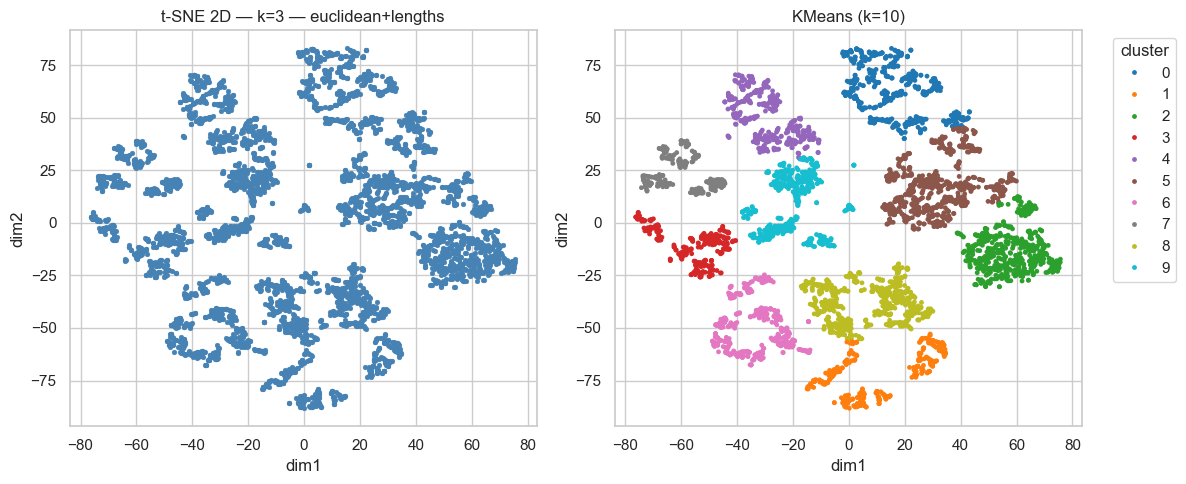

In [18]:
k = 3
dfk = df[df['count_of_chunks'] == k].head(5000).copy()

# Filter columns valid for this k
all_numeric_k = filter_cols_for_k(base_numeric, k)
cos_k = filter_cols_for_k(cosine_cols_all, k)
euc_k = filter_cols_for_k(euclid_cols_all, k)
len_k = filter_cols_for_k(length_cols_all, k)
features_k = {
    'cosine_only': cos_k,
    'euclidean_only': euc_k,
    'lengths_only': len_k,
    'cosine+lengths': list(dict.fromkeys(cos_k + len_k)),
    'euclidean+lengths': list(dict.fromkeys(euc_k + len_k)),
    # Optionally: 'all_numeric': all_numeric_k,  # excluded to avoid mixing any non-chunk-indexed cols
}


set_name = 'euclidean+lengths'
cols = features_k[set_name]

X = prep_feature_matrix(dfk, cols)
Xs, scaler = standardize(X)


# t-SNE
print('Computing t-SNE 2D (may subsample for speed)...')
Z_tsne = embed_tsne(Xs, random_state=RANDOM_STATE, max_samples=5000)
best_km_tsne = best_kmeans(Z_tsne)
fig, axes = plt.subplots(1, 2, figsize=(12,5))
plot_embedding(Z_tsne, None, title=f't-SNE 2D — k={k} — {set_name}', ax=axes[0])
if best_km_tsne is not None:
    plot_embedding(Z_tsne, best_km_tsne['labels'], title=f'KMeans (k={best_km_tsne["k"]})', ax=axes[1])
else:
    axes[1].set_title('KMeans — no clusters')
plt.tight_layout()
plt.show()


In [13]:
dfk[dfk.corpus.isin(['árnyalat', 'mészárszék', 'dehidratál', 'borzadalom'])]

Empty DataFrame
Columns: [count_of_chunks, corpus, chunk1, chunk2, chunk3, chunk4, chunk5, cosine_distance_chunk1_and_chunk2, cosine_distance_chunk1_and_chunk3, cosine_distance_chunk1_and_chunk4, cosine_distance_chunk1_and_chunk5, cosine_distance_chunk2_and_chunk3, cosine_distance_chunk2_and_chunk4, cosine_distance_chunk2_and_chunk5, cosine_distance_chunk3_and_chunk4, cosine_distance_chunk3_and_chunk5, cosine_distance_chunk4_and_chunk5, cosine_corpus_and_chunk2, cosine_corpus_and_chunk3, cosine_corpus_and_chunk4, cosine_corpus_and_chunk5, euclidean_distance_chunk1_and_chunk2, euclidean_distance_chunk1_and_chunk3, euclidean_distance_chunk1_and_chunk4, euclidean_distance_chunk1_and_chunk5, euclidean_distance_chunk2_and_chunk3, euclidean_distance_chunk2_and_chunk4, euclidean_distance_chunk2_and_chunk5, euclidean_distance_chunk3_and_chunk4, euclidean_distance_chunk3_and_chunk5, euclidean_distance_chunk4_and_chunk5, euclidean_corpus_and_chunk2, euclidean_corpus_and_chunk3, euclidean_corpus_and_chunk4, euclidean_corpus_and_chunk5, cosine_corpus_and_chunk1, euclidean_corpus_and_chunk1, length_chunk1, length_chunk2, length_chunk3, length_chunk4, length_chunk5]
Index: []

[0 rows x 42 columns]

In [26]:
dfk[best_km_tsne['labels'] == 7]

count_of_chunks         corpus chunk1     chunk2 chunk3 chunk4 chunk5  \
21846                3     egyáltalán    egy      által     án    NaN    NaN   
21865                3      tökéletes    tök       élet     es    NaN    NaN   
21870                3     egyszerűen    egy      szerű     en    NaN    NaN   
21912                3       amerikai     am       erik     ai    NaN    NaN   
21920                3       értettem     ér       tett     em    NaN    NaN   
...                ...            ...    ...        ...    ...    ...    ...   
26708                3  öngyilkossági     ön  gyilkossá     gi    NaN    NaN   
26714                3    munkatársam  munka       társ     am    NaN    NaN   
26729                3     mérfölddel    mér       föld    del    NaN    NaN   
26738                3       részemet     ré       szem     et    NaN    NaN   
26790                3    hozzámentem  hozzá       ment     em    NaN    NaN   

       cosine_distance_chunk1_and_chunk2  cosine_distance_chunk1_and_chunk3  \
21846                           0.641721                           1.011902   
21865                           0.777590                           0.981522   
21870                           0.734761                           1.034683   
21912                           0.795614                           0.627481   
21920                           0.839685                           0.695882   
...                                  ...                                ...   
26708                           0.891286                           0.635242   
26714                           0.614061                           1.058768   
26729                           0.802966                           0.896079   
26738                           0.945399                           0.632232   
26790                           0.672906                           1.049177   

       cosine_distance_chunk1_and_chunk4  ...  euclidean_corpus_and_chunk3  \
21846                                0.0  ...                     3.534862   
21865                                0.0  ...                     2.802994   
21870                                0.0  ...                     2.989998   
21912                                0.0  ...                     3.181158   
21920                                0.0  ...                     3.905684   
...                                  ...  ...                          ...   
26708                                0.0  ...                     4.228199   
26714                                0.0  ...                     3.770787   
26729                                0.0  ...                     2.889921   
26738                                0.0  ...                     3.654847   
26790                                0.0  ...                     3.914771   

       euclidean_corpus_and_chunk4  euclidean_corpus_and_chunk5  \
21846                          0.0                          0.0   
21865                          0.0                          0.0   
21870                          0.0                          0.0   
21912                          0.0                          0.0   
21920                          0.0                          0.0   
...                            ...                          ...   
26708                          0.0                          0.0   
26714                          0.0                          0.0   
26729                          0.0                          0.0   
26738                          0.0                          0.0   
26790                          0.0                          0.0   

       cosine_corpus_and_chunk1  euclidean_corpus_and_chunk1  length_chunk1  \
21846                  0.525573                     1.447845              3   
21865                  0.584976                     1.679573              3   
21870                  0.524170                     1.439677              3   
21912                  0.983307        